<a href="https://colab.research.google.com/github/jumbokh/csu1112-class/blob/main/notebooks/%E7%AC%AC9%E7%AB%A0_%E6%99%82%E9%96%93%E5%BA%8F%E5%88%97%E5%88%86%E6%9E%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 深度學習：時間序列分析

為了便於下面的程式執行，先將必要的軟體程式庫提前載入目前系統。這些常用的軟體程式庫包括pandas，numpy，matplotlib以及statsmodels，當然還有keras。

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
from time import time
import statsmodels.api as sm
import matplotlib.pyplot as plt
import keras
import keras.models as kModels
import keras.layers as kLayers

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from scipy.signal import periodogram
# warnings package is to eliminate annoying warning message from KPSS test
import warnings

from statsmodels.tsa.stattools import acf
from scipy import signal
#if you don't have peakutils package, install it by: pip install peakutils
try:
    import peakutils as peak
except ImportError:
    !pip install peakutils
    import peakutils as peak

plt.rcParams['figure.figsize']=(20, 10)
font = {'size'   : 20}
plt.rc('font', **font)

C:\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
Using CNTK backend
C:\Anaconda3\lib\site-packages\keras\backend\cntk_backend.py:21: UserWarning: CNTK backend warning: GPU is not detected. CNTK's CPU version is not fully optimized,please run with GPU to get better performance.
  'CNTK backend warning: GPU is not detected. '


In [ ]:
np.random.seed(897871)
print(sm.version.full_version)

0.8.0


產生白色雜訊和隨機行走序列

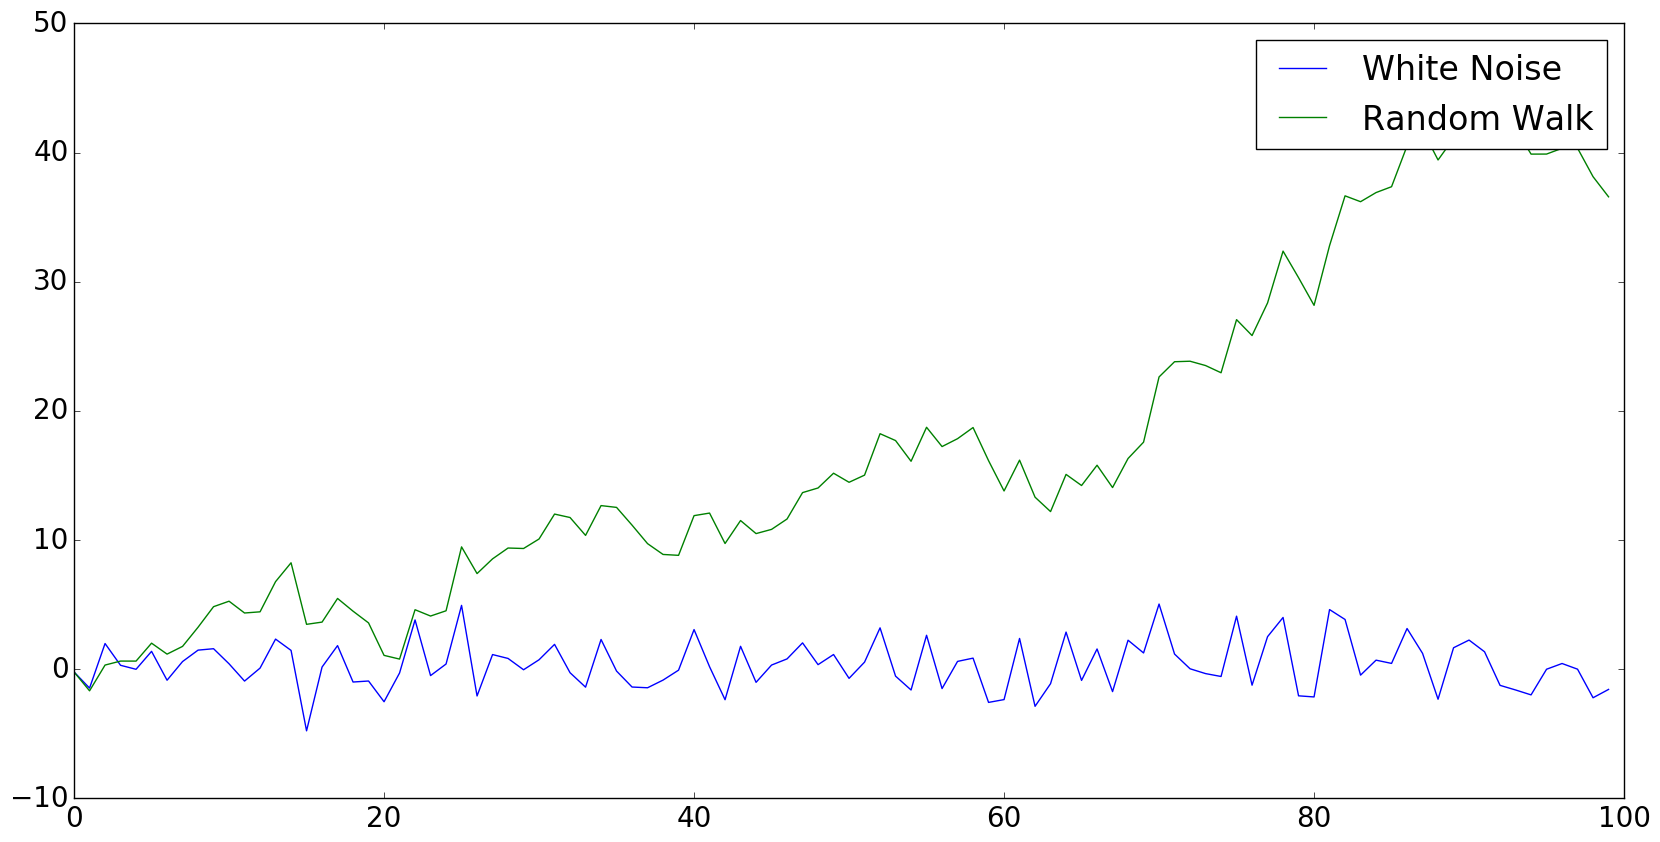

前20個資料點的均值為3.1296, 標準差為2.4466

後20個資料點的均值為38.9727, 標準差為3.7553


In [ ]:
np.random.seed(1291)
z = np.random.normal(0.1, 2, 100)
y = np.cumsum(z)

fig, ax1 = plt.subplots()
plt.plot(z, label="White Noise")
plt.plot(y, label="Random Walk")
plt.legend()
plt.savefig('./data/timeseries/WhiteNoise.png')

plt.show()

mean1 = np.round(np.mean(y[:20]), 4); mean2=np.round(np.mean(y[-20:]), 4)
std1 = np.round(np.std(y[:20]), 4); std2=np.round(np.std(y[-20:]), 4)


print("前20個資料點的均值為%.4f, 標準差為%.4f" %(mean1, std1))
print("")
print("後20個資料點的均值為%.4f, 標準差為%.4f" %(mean2, std2))

plt.close()
plt.show()

## 範例資料

時間序列資料來自於 DataMarket 的時間序列資料庫： https://datamarket.com/data/list/?q=provider:tsdl 。 這個資料庫由澳洲莫納什大學的統計學教授 Rob Hyndman 建立，收集了數十個公開的時間序列資料集。Rob Hyndman教授也是R統計語言裡面forecast套裝軟體的開發者。本章採用其中兩種資料作為實例。為了方便讀者，都已經存入本地資料夾

第一個資料是在漢口測量的長江每月流量資料作為實例，該資料記錄了從1865年一月到1978年十二月間在漢口記錄的長江每月流量，總計1368個資料點，計量單位未知，不過不妨礙我們的分析過程和結果。我們將該資料下載後存入本地磁片，路徑為：..\.\data\TimeSeries\， 檔案名為monthly-flows-chang-jiang-at-hankou.csv。從下圖可以看出，該資料具備很強的不同長度的週期性。

   YearMonth  WaterFlow
0 1865-01-01       3880
1 1865-02-01       3290
2 1865-03-01       4910
3 1865-04-01       8760
4 1865-05-01      13800


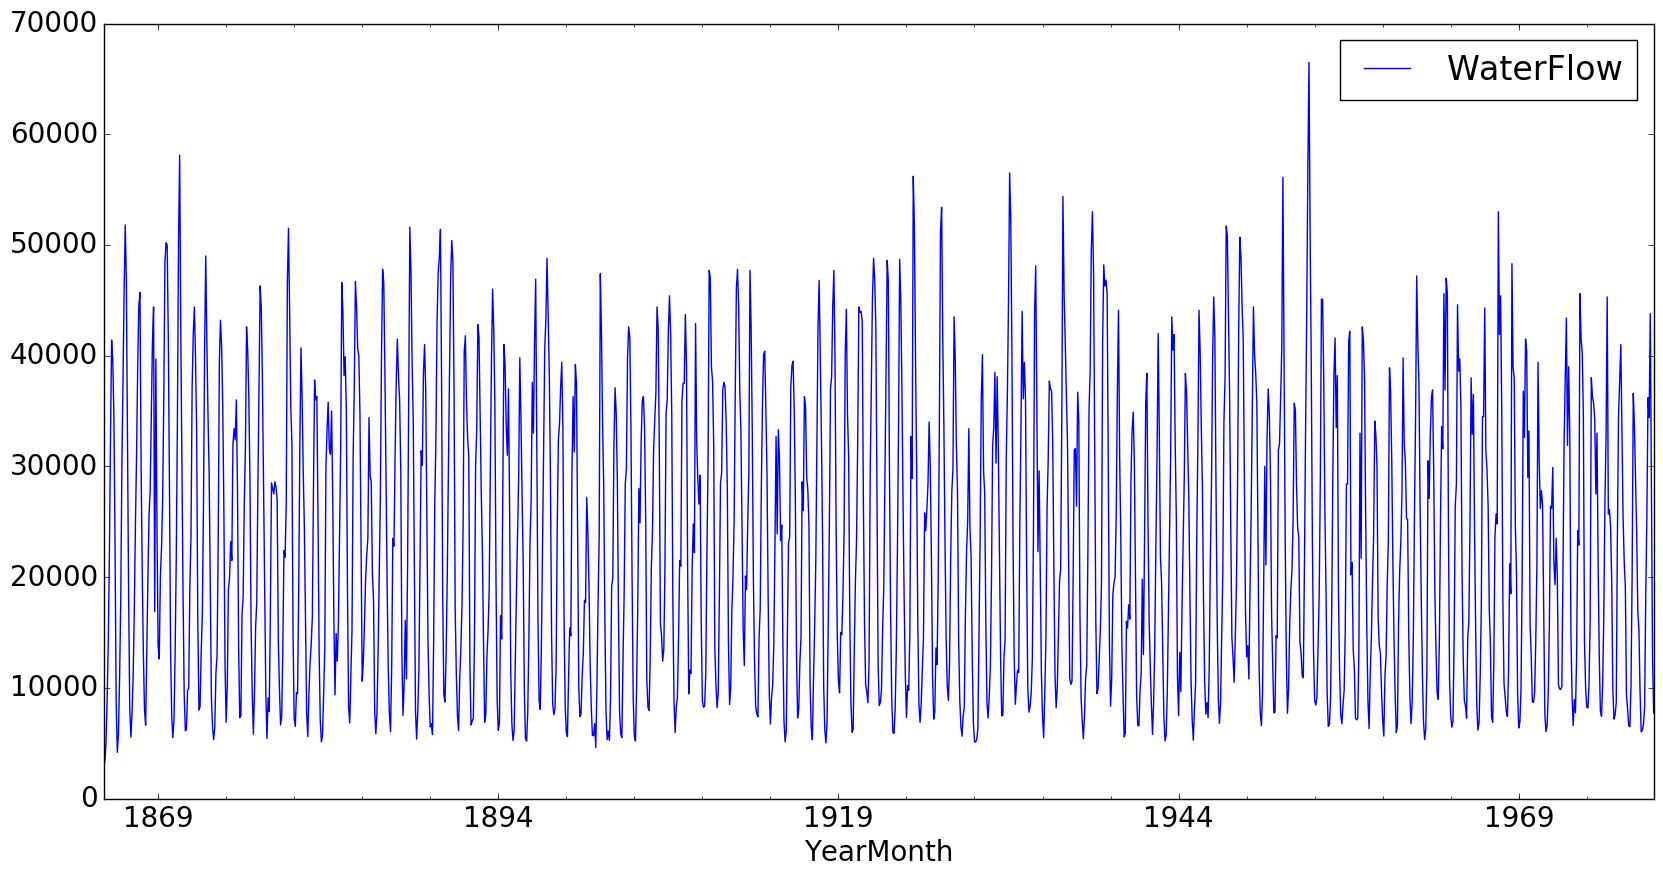

In [ ]:
parser = lambda date: pd.datetime.strptime(date, '%Y-%m')
df1 = pd.read_csv("./data/timeseries/monthly-flows-chang-jiang-at-hankou.csv", 
                 engine="python", skipfooter=3, names=["YearMonth", "WaterFlow"], 
                 parse_dates=[0], infer_datetime_format=True, date_parser=parser, 
                 header=0)
print(df1.head())
df1.YearMonth = pd.to_datetime(df1.YearMonth)
df1.set_index("YearMonth", inplace=True)
df1.plot()
plt.savefig('./data/timeseries/WaterFlow.png')
plt.show()


第二個資料是1949年一月到1960年十二月的月度國際航空旅客數量。該資料有144個資料點，資料單位為千人，與第一個資料不同的是該資料包含極強的趨勢要素和週期要素，因此在具體的分析上能體現不同的要求。該數據下載後在本地磁盤存為：./data/TimeSeries/international-airline-passengers.csv 。下面我們讀入該資料，並展示。

            Passenger
YearMonth            
1949-01-01        112
1949-02-01        118
1949-03-01        132
1949-04-01        129
1949-05-01        121


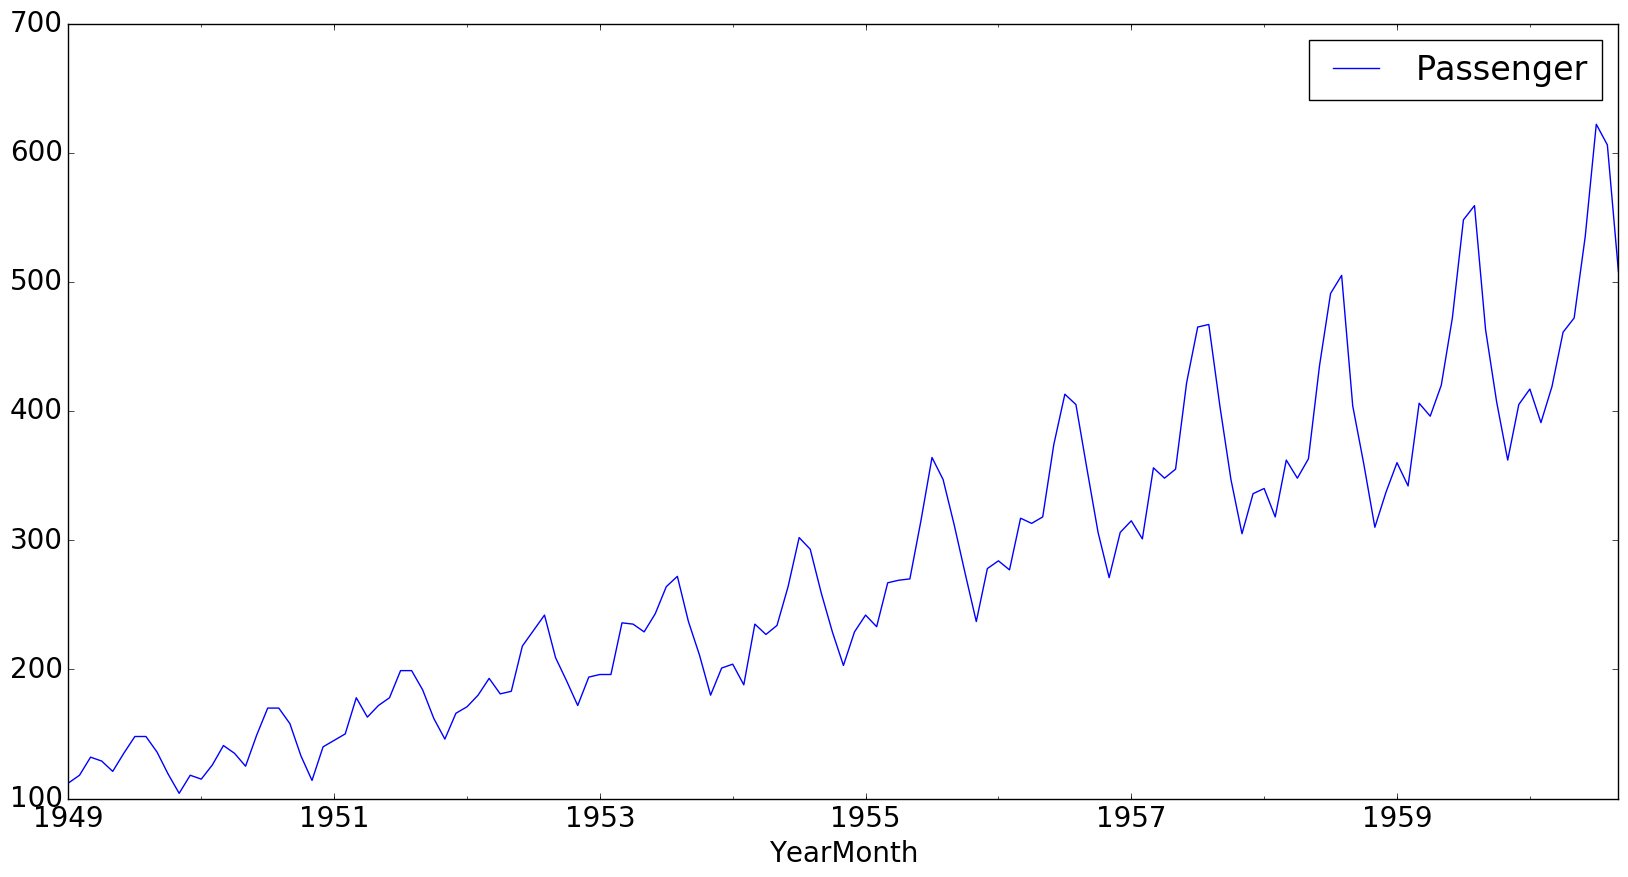

In [ ]:
parser = lambda date: pd.datetime.strptime(date, '%b-%y')

df2 = pd.read_csv("./data/timeseries/international-airline-passengers.csv", 
                 engine="python", skipfooter=3, names=["YearMonth", "Passenger"],                   
                 header=0)

df2.YearMonth = df2.YearMonth.str[:4]+'19'+df2.YearMonth.str[-2:]
df2.YearMonth = pd.to_datetime(df2.YearMonth, infer_datetime_format=True)
df2.set_index("YearMonth", inplace=True)
print(df2.head())
df2.plot(fontsize=20)
plt.savefig('./data/timeseries/Passenger.png')
plt.show()
plt.close()

下面對資料的平穩性進行檢驗，使用ADF和KPSS兩個統計測試量。同時產生其自相關和偏自相關圖。需要注意的是KPSS測試在p值過小或者過大的情況下，會列印“警告”warnings資訊。出於排版美觀的要求，我們在下面的檢驗中，使用了warnings軟體庫裡的catch_warnings方法來對KPSS函數的warnings列印資訊進行控制，直接忽略不列印。

ADF test result on Difference shows test statistic is -3.045022 and p-value is 0.030898
ADF test result on Log Difference shows test statistic is -2.706950 and p-value is 0.072843
KPSS test result on Difference shows test statistic is 0.078160 and p-value is 0.100000
KPSS test result on Log difference shows test statistic is 0.059560 and p-value is 0.100000


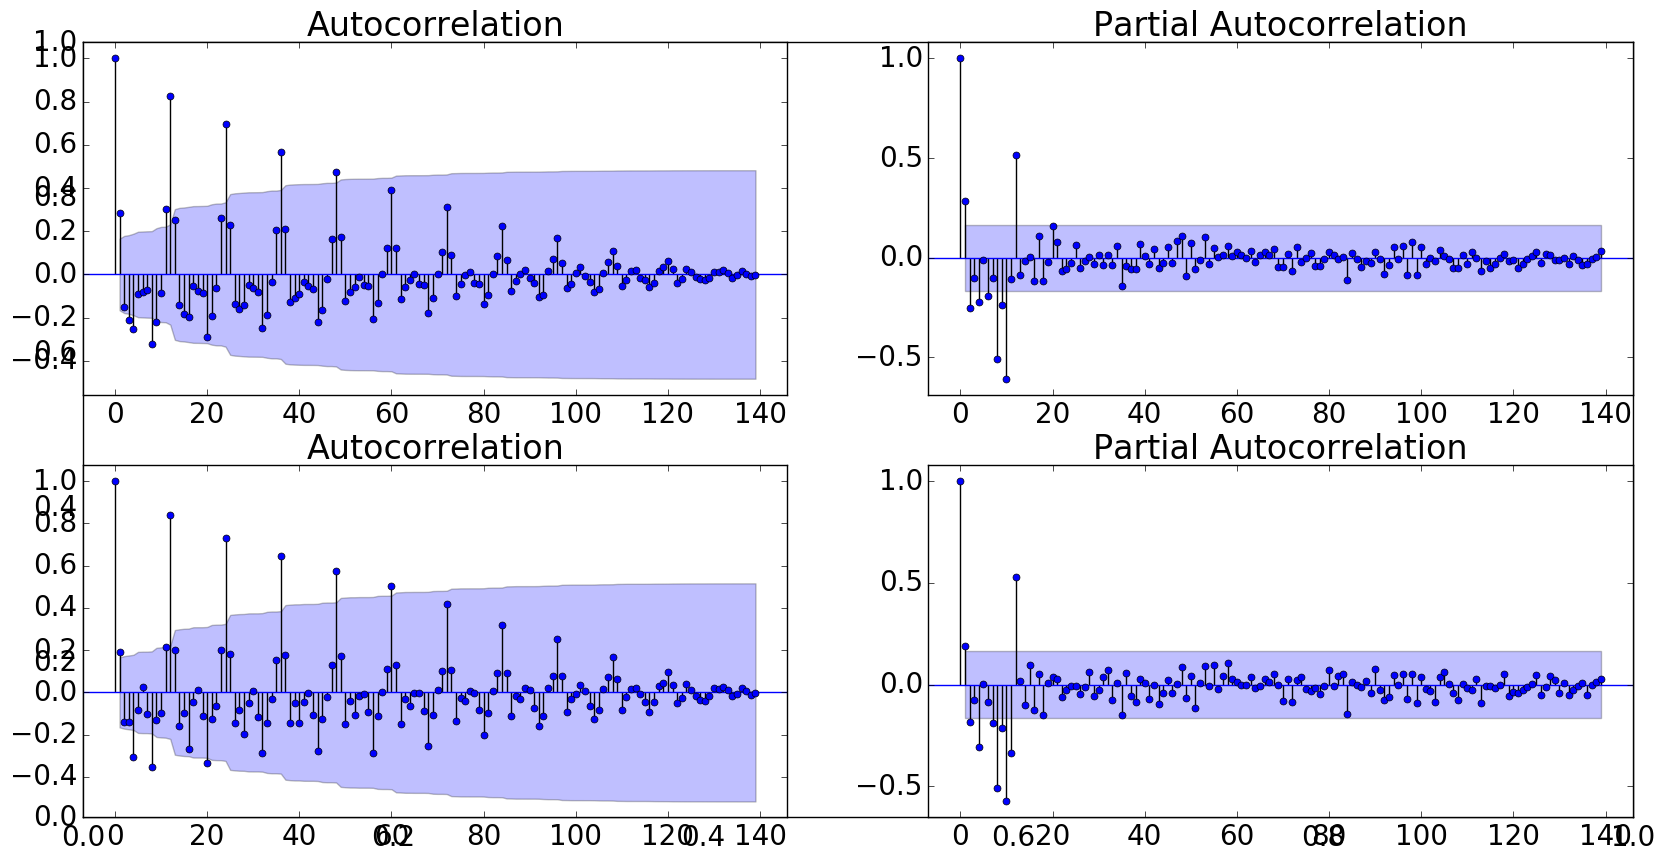

In [ ]:
# test stationarity
order=1
diff1 = df2.Passenger.diff(order)[order:]
logdiff1 = np.log(df2.Passenger).diff(order)[order:]
adftest = sm.tsa.stattools.adfuller(diff1)
adftestlog = sm.tsa.stattools.adfuller(logdiff1)
print("ADF test result on Difference shows test statistic is %f \
and p-value is %f" %(adftest[:2]))
print("ADF test result on Log Difference shows test statistic is %f \
and p-value is %f" %(adftestlog[:2]))

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    kpsstest = sm.tsa.stattools.kpss(diff1)
    kpsstestlog=sm.tsa.stattools.kpss(logdiff1)
    
print("KPSS test result on Difference shows test statistic is %f \
and p-value is %f" %(kpsstest[:2]))
print("KPSS test result on Log difference shows test statistic is %f \
and p-value is %f" %(kpsstestlog[:2]))

# compute and visualize ACF, PACF
fig, ax = plt.subplots()
ax1=fig.add_subplot(221)
sm.graphics.tsa.plot_acf(diff1, ax=ax1); 

ax2=fig.add_subplot(222)
sm.graphics.tsa.plot_pacf(diff1, ax=ax2); 

ax3 = fig.add_subplot(223)
sm.graphics.tsa.plot_acf(logdiff1, ax=ax3);

ax4=fig.add_subplot(224)
sm.graphics.tsa.plot_pacf(logdiff1, ax=ax4); 

plt.savefig('./data/timeseries/ACF_PACF_diff1.png')
plt.show()

plt.close()

下面對長江漢口月度水量使用傳統的SARIMA模型進行建模

In [ ]:
def test_stationarity(timeseries, window=12): 
    df = pd.DataFrame(timeseries)
    df['Rolling.Mean'] = timeseries.rolling(window=window).mean()
    df['Rolling.Std']=timeseries.rolling(window=window).std()
    adftest = sm.tsa.stattools.adfuller(timeseries)
    adfoutput = pd.Series(adftest[0:4], index=['統計量','p-值 ','滯後量','觀測值數量'])
    for key,value in adftest[4].items():
        adfoutput['臨界值 (%s)'% key] = value
    return(adfoutput, df)

def CalculateCycle(ts, lags=36):  
    acf_x, acf_ci = acf(ts, alpha=0.05, nlags=lags)
    fs=1
    f, Pxx_den = signal.periodogram(acf_x, fs)
    
    index = peak.indexes(Pxx_den)
    cycle=(1/f[index[0]]).astype(int)
    fig = plt.figure()
    ax0 = fig.add_subplot(111)
    plt.vlines(f, 0, Pxx_den)
    plt.axhline(y=0)
    plt.plot(f[index], Pxx_den[index], marker='o', linestyle='none', color='red')
    plt.title("Identified Cycle of %i" % (cycle))
    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')
    plt.show()
    return( index, f, Pxx_den)

原始資料平穩性檢驗
統計量            -5.147438
p-值             0.000011
滯後量            23.000000
觀測值數量        1320.000000
臨界值 (5%)       -2.863732
臨界值 (10%)      -2.567937
臨界值 (1%)       -3.435314
dtype: float64
局部資料平穩性檢驗
統計量           -2.943085
p-值            0.040562
滯後量           12.000000
觀測值數量        179.000000
臨界值 (5%)      -2.877826
臨界值 (10%)     -2.575452
臨界值 (1%)      -3.467420
dtype: float64
ADF test result shows test statistic is -13.013917 and p-value is 0.000000


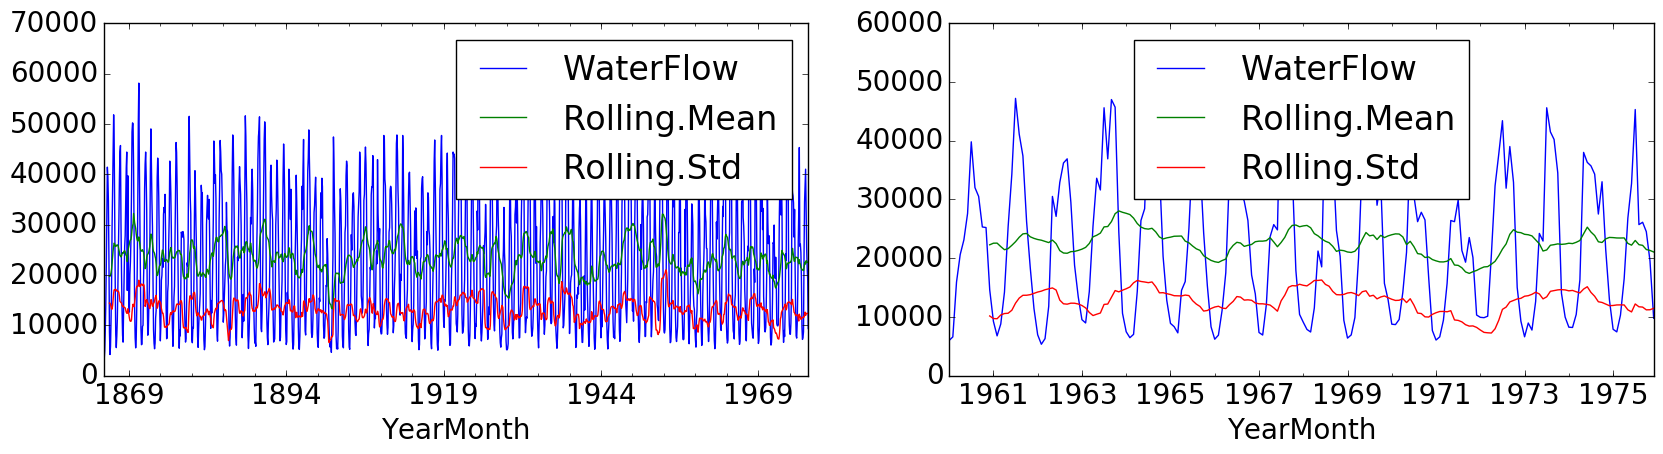

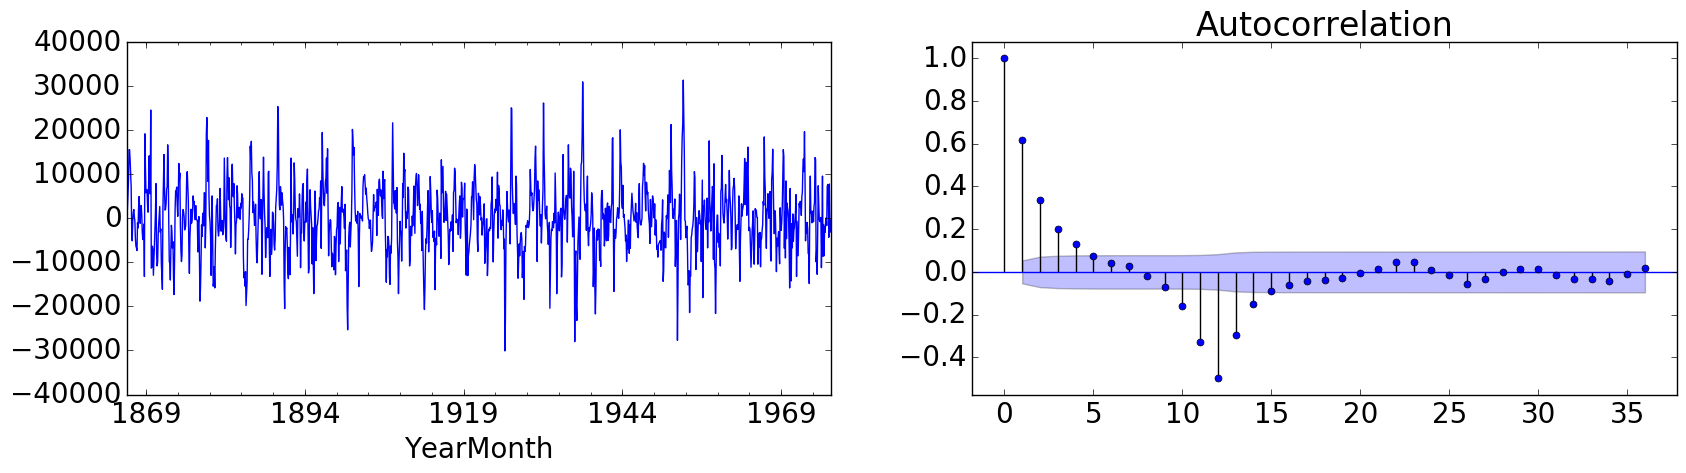

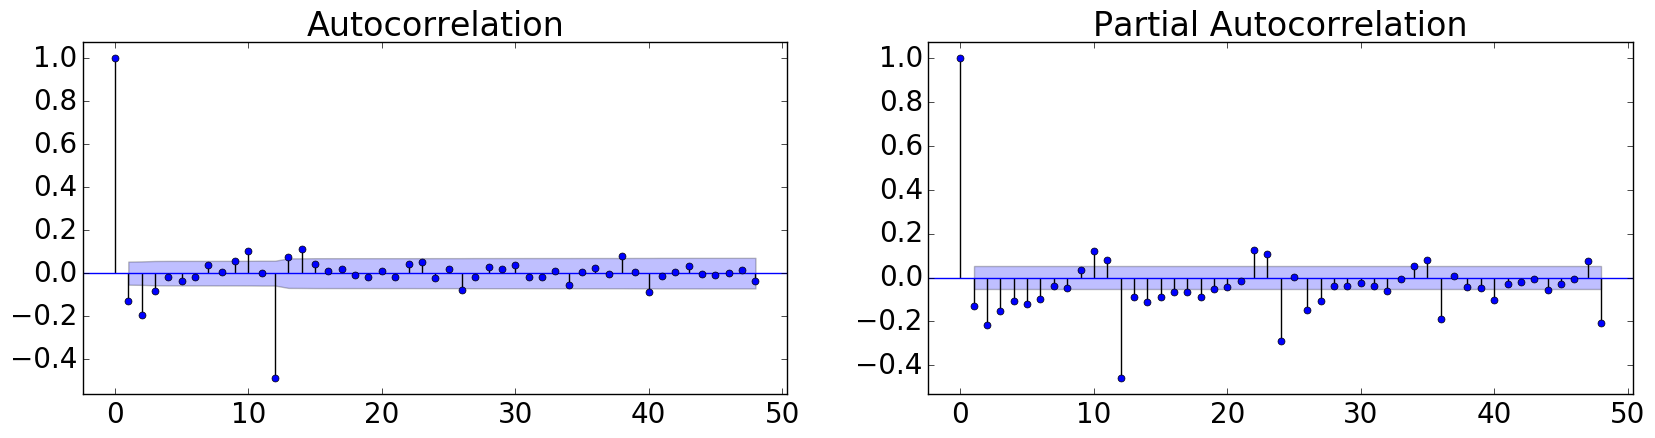

                                 Statespace Model Results                                 
Dep. Variable:                          WaterFlow   No. Observations:                 1344
Model:             SARIMAX(0, 1, 0)x(0, 1, 1, 12)   Log Likelihood              -13198.909
Date:                            Thu, 26 Apr 2018   AIC                          26401.819
Time:                                    17:53:42   BIC                          26412.226
Sample:                                01-01-1865   HQIC                         26405.717
                                     - 12-01-1976                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.9474      0.009   -102.636      0.000      -0.965      -0.929
sigma2      2.368e+07   2.22e-11   

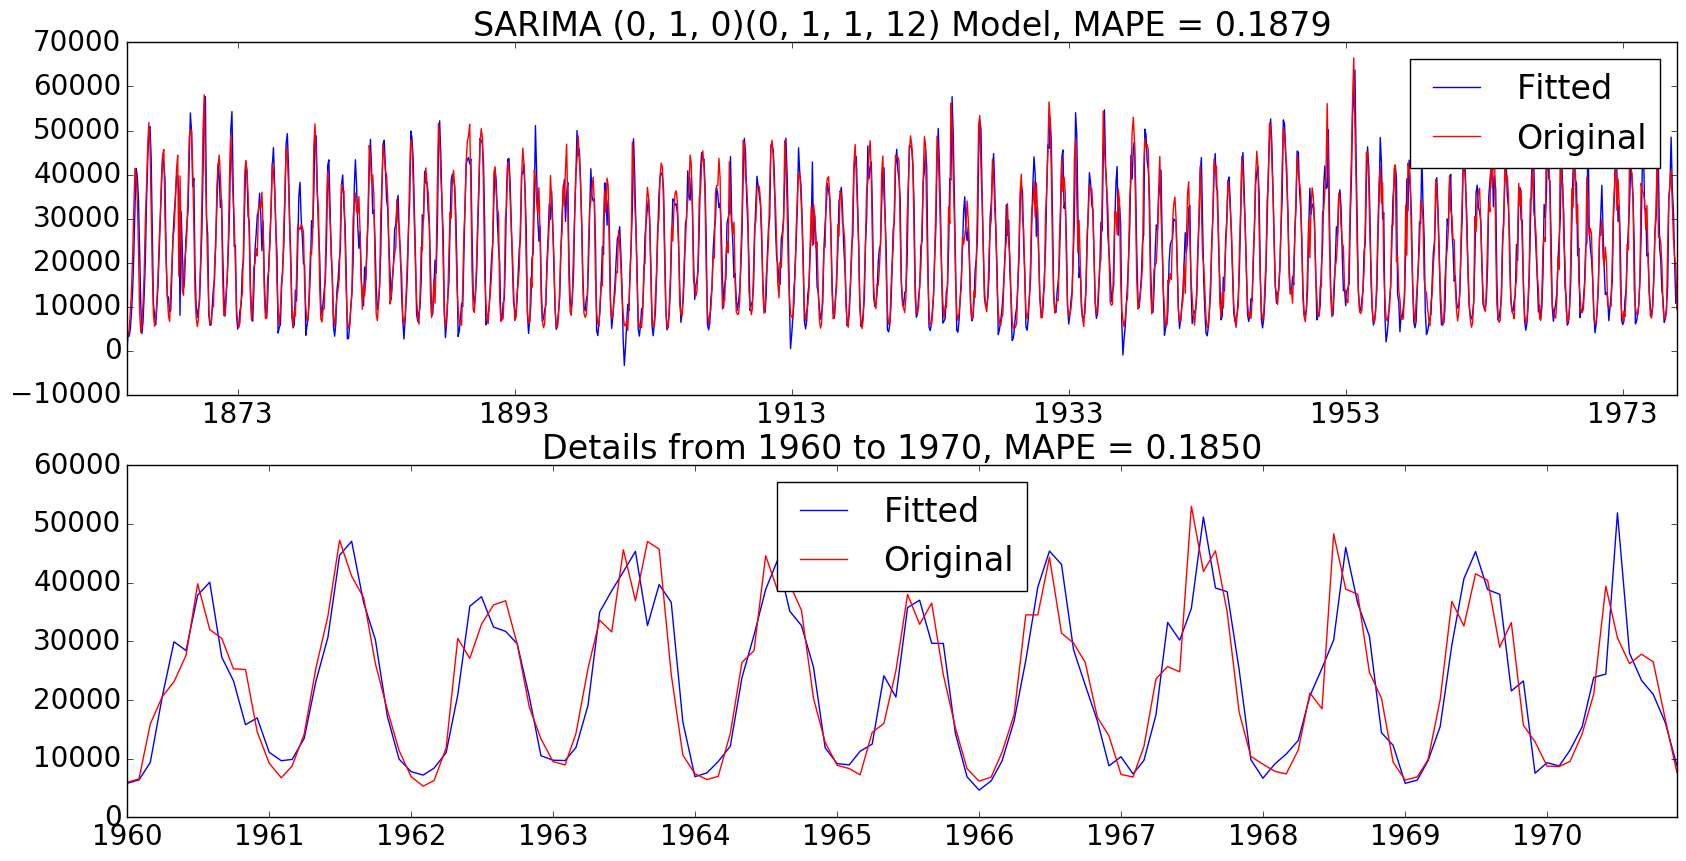

In [ ]:
# build SARIMA model

cutoff=24
train = df1.WaterFlow[:-cutoff]
test = df1.WaterFlow[-cutoff:]
startYear = '1960'
endYear = '1975'

# check stationarity first
fig = plt.figure()
ax0 = fig.add_subplot(221)
adftest, dftest0=test_stationarity(train)
dftest0.plot(ax=ax0)
print('原始資料平穩性檢驗')
print(adftest)

ax1 = fig.add_subplot(222)
adftest, dftest1=test_stationarity(train[startYear:endYear])
dftest1.plot(ax=ax1)
print('局部資料平穩性檢驗')
print(adftest)


# test stationarity after removing seasonality
Seasonality=12
waterFlowS12 = train.diff(Seasonality)[Seasonality:]
waterFlowS12d1 = waterFlowS12.diff(1)[1:]
adftestS12 = sm.tsa.stattools.adfuller(waterFlowS12)
print("ADF test result shows test statistic is %f and p-value is %f" %(adftestS12[:2]))

nlag=36
xvalues = np.arange(nlag+1)

acfS12, confiS12 = sm.tsa.stattools.acf(waterFlowS12, nlags=nlag, alpha=0.05, fft=False)
confiS12 = confiS12 - confiS12.mean(1)[:,None]

fig = plt.figure()
ax0 = fig.add_subplot(221)
waterFlowS12.plot(ax=ax0)

ax1=fig.add_subplot(222)
sm.graphics.tsa.plot_acf(waterFlowS12, lags=nlag, ax=ax1)
plt.show()

fig = plt.figure()
ax0 = fig.add_subplot(221)
sm.graphics.tsa.plot_acf(waterFlowS12d1, ax=ax0, lags=48)
ax1 = fig.add_subplot(222)
sm.graphics.tsa.plot_pacf(waterFlowS12d1, ax=ax1, lags=48)
plt.show()

# Build SARIMA
arima_order1=(0,1,0)
season_order1=(0,1,1,12)
mod1 = sm.tsa.statespace.SARIMAX(train, trend='n', order=arima_order1, seasonal_order=season_order1).fit()
pred=mod1.predict()
print(mod1.summary())

# check validation results
subtrain = train['1960':'1970']
MAPE = (np.abs(train-pred)/train).mean()
subMAPE = (np.abs(subtrain-pred['1960':'1970'])/train).mean()

fig = plt.figure()
ax0 = fig.add_subplot(211)
plt.plot(pred, label='Fitted');
plt.plot(train, color='red', label='Original')
plt.legend(loc='best')
plt.title("SARIMA %s%s Model, MAPE = %.4f" % (arima_order1, season_order1, MAPE))

ax1 = fig.add_subplot(212)
plt.plot(pred['1960':'1970'], label='Fitted');
plt.plot(subtrain, color='red', label='Original')
plt.legend(loc='best')
plt.title("Details from 1960 to 1970, MAPE = %.4f" % subMAPE)
plt.show()

測試不同參數的SARIMA模型

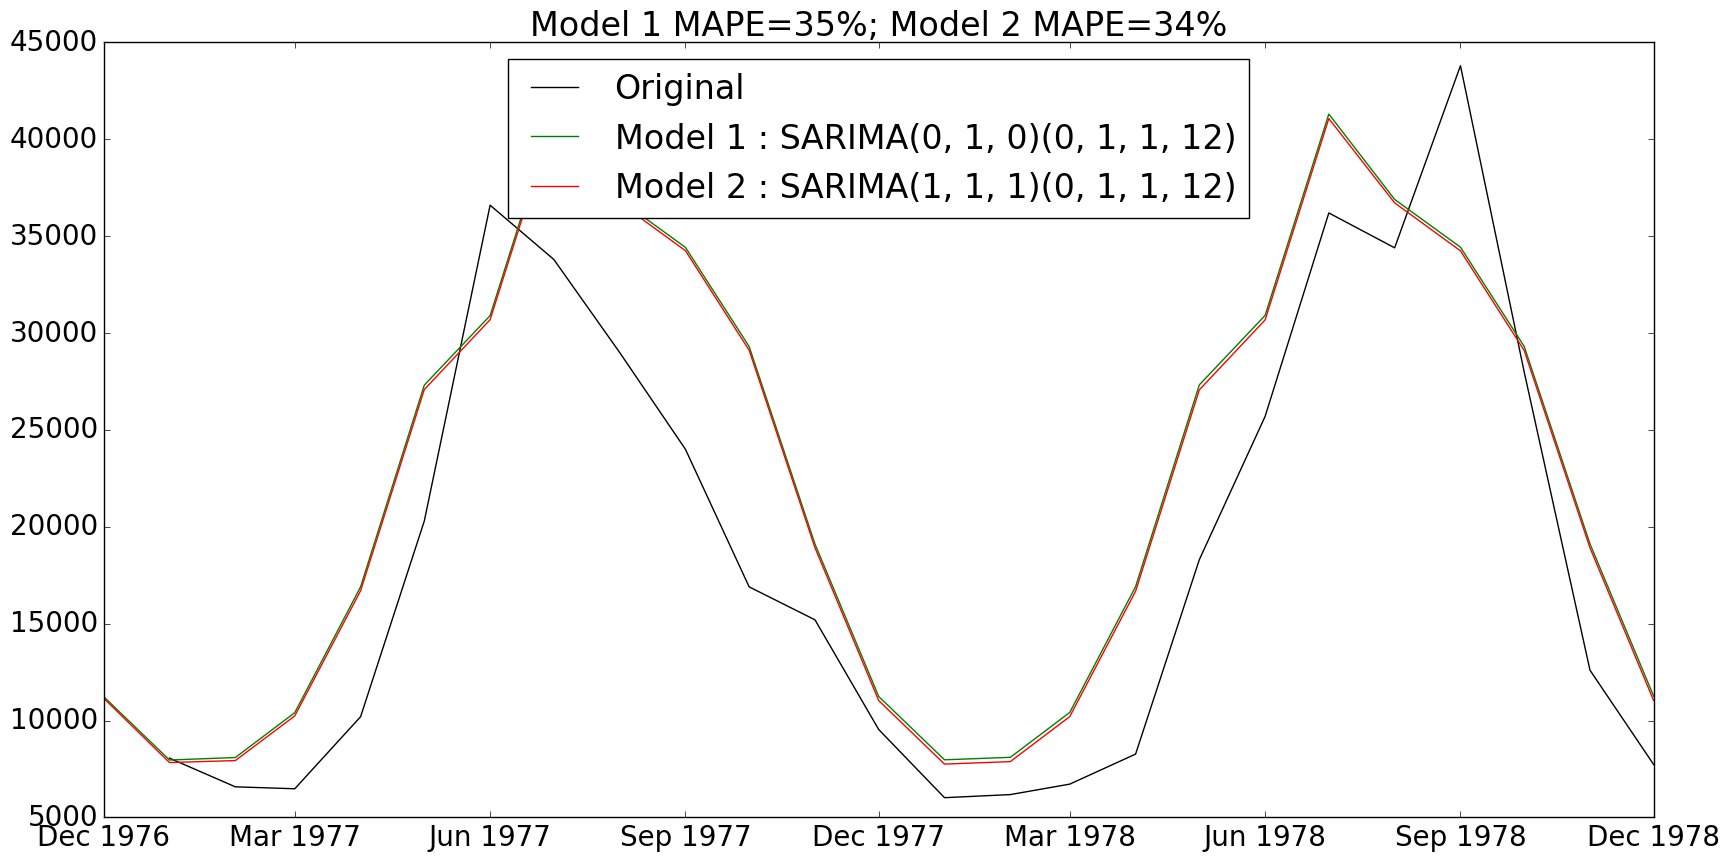

In [ ]:
# test alternatives
arima_order2 = (1,1,1)
season_order2 = (0,1,1,12)
mod2 = sm.tsa.statespace.SARIMAX(train, trend='n', order=arima_order2, seasonal_order=season_order2).fit()
forecast1 = mod1.predict(start = '1976-12-01', end='1978' , dynamic= True)
forecast2 = mod2.predict(start = '1976-12-01', end='1978' , dynamic= True)
MAPE1 = ((test-forecast1).abs() / test).mean()*100
MAPE2 = ((test-forecast2).abs() / test).mean()*100

plt.plot(test, color='black', label='Original')
plt.plot(forecast1, color='green', label='Model 1 : SARIMA'+ str(arima_order1) + str(season_order1))
plt.plot(forecast2, color='red', label='Model 2 : SARIMA'+ str(arima_order2) + str(season_order2))
plt.legend(loc='best')
plt.title('Model 1 MAPE=%.f%%; Model 2 MAPE=%.f%%'%(MAPE1, MAPE2))

下面使用深度學習的LSTM模型對流量資料進行建模。首先定義資料產生函數。

In [ ]:
from statsmodels.tsa.tsatools import lagmat

# define function to create data we need
def create_dataset(dataset, timestep=1, look_back=1, look_ahead=1):
    ds = dataset.reshape(-1, 1)    
    dataX = lagmat(dataset, maxlag=timestep*look_back, trim="both", original='ex')
    dataY = lagmat(dataset[(timestep*look_back):], maxlag=look_ahead, trim="backward", original='ex')
    # reshape and remove redundent rows
    dataX = dataX.reshape(dataX.shape[0], timestep, look_back)[:-(look_ahead-1)]
    return np.array(dataX), np.array(dataY[:-(look_ahead-1)])

檢驗該函數的正確性

In [ ]:
temp = np.arange(100)+1
tempX, tempY = create_dataset(temp, timestep=3, look_back= 2, look_ahead=2)
print(tempY[-1, :])
print(tempX[-1, :, :])

[ 100.   99.]
[[ 98.  97.]
 [ 96.  95.]
 [ 94.  93.]]


進行資料準備工作

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
trainstd = scaler.fit_transform(train.values.astype(float).reshape(-1, 1))
teststd = scaler.transform(test.values.astype(float).reshape(-1, 1))

lookback=60
lookahead=24
timestep=1
trainX, trainY = create_dataset(trainstd, timestep=1, look_back=lookback, look_ahead=lookahead)
trainX = trainX.astype('float32')
trainY = trainY.astype('float32')

定義並訓練我們的簡單LSTM模型

In [ ]:
# define LSTM model 
batch_size=1
model = kModels.Sequential()
model.add(kLayers.LSTM(48, batch_size=batch_size, input_shape=(1, lookback), kernel_initializer='he_uniform'))
model.add(kLayers.Dense(lookahead))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=20, batch_size=batch_size, verbose=1)

Epoch 1/20
1261/1261 [==============================] - 13s 10ms/step - loss: 0.0129
Epoch 2/20
1261/1261 [==============================] - 12s 9ms/step - loss: 0.0090
Epoch 3/20
1261/1261 [==============================] - 12s 9ms/step - loss: 0.0087
Epoch 4/20
1261/1261 [==============================] - 13s 10ms/step - loss: 0.0085
Epoch 5/20
1261/1261 [==============================] - 12s 9ms/step - loss: 0.0084
Epoch 6/20
1261/1261 [==============================] - 12s 9ms/step - loss: 0.0084
Epoch 7/20
1261/1261 [==============================] - 13s 10ms/step - loss: 0.0083
Epoch 8/20
1261/1261 [==============================] - 13s 10ms/step - loss: 0.0082
Epoch 9/20
1261/1261 [==============================] - 13s 10ms/step - loss: 0.0081
Epoch 10/20
1261/1261 [==============================] - 12s 10ms/step - loss: 0.0081
Epoch 11/20
1261/1261 [==============================] - 12s 9ms/step - loss: 0.0080
Epoch 12/20
1261/1261 [==============================] - 11s 9ms/ste

下面使用訓練後得到的模型進行預測並顯示預測結果

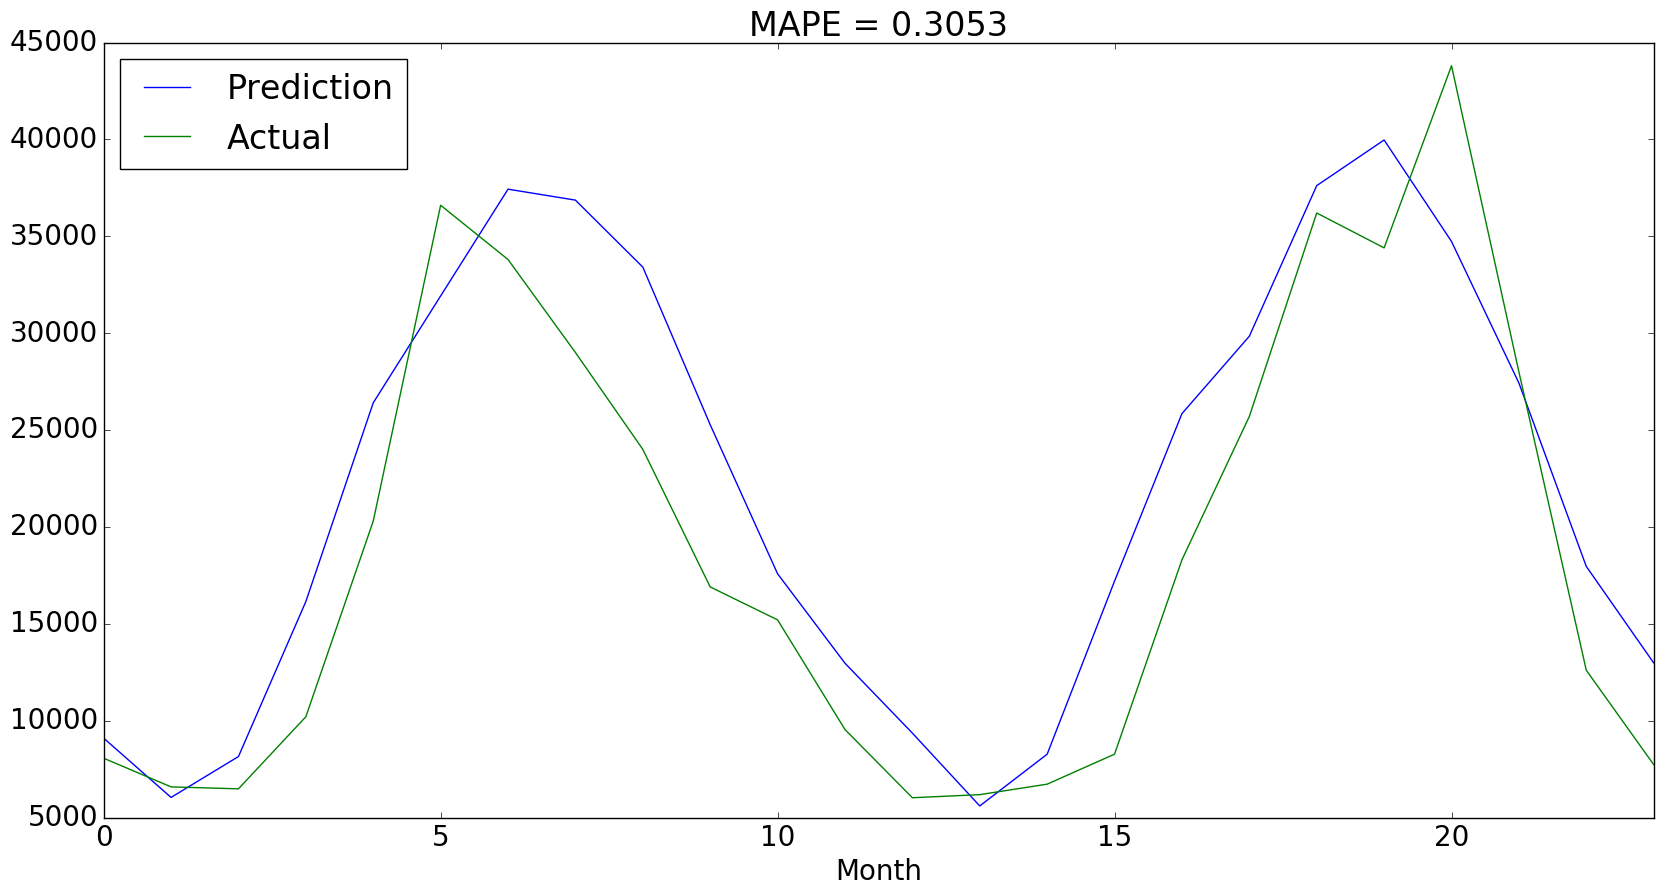

In [ ]:
# visual 
feedData = scaler.transform(df1.WaterFlow['1972':'1976'].values.reshape(-1, 1)).copy()
feedX = (feedData).reshape(1, 1, lookback)
feedX = (feedX).astype('float32')
prediction1 = model.predict(feedX)

predictionRaw = scaler.inverse_transform(prediction1.reshape(-1, 1))
actual1 = df1.WaterFlow['1977':'1978'].copy().values.reshape(-1, 1)
MAPE = (np.abs(predictionRaw-actual1)/actual1).mean()

plt.plot(predictionRaw, label='Prediction')
plt.plot(actual1, label='Actual')
plt.title("MAPE = %.4f" % MAPE)
plt.legend(loc='best')
plt.xlim((0, 23))
plt.xlabel("Month")
plt.show()

疊加LSTM模型

Epoch 1/15
1261/1261 [==============================] - 1s 532us/step - loss: 83.1485
Epoch 2/15
1261/1261 [==============================] - 1s 473us/step - loss: 68.5441
Epoch 3/15
1261/1261 [==============================] - 0s 314us/step - loss: 65.2314
Epoch 4/15
1261/1261 [==============================] - 0s 349us/step - loss: 62.1835
Epoch 5/15
1261/1261 [==============================] - 0s 323us/step - loss: 56.5588
Epoch 6/15
1261/1261 [==============================] - 0s 309us/step - loss: 45.5326
Epoch 7/15
1261/1261 [==============================] - 0s 311us/step - loss: 36.0540
Epoch 8/15
1261/1261 [==============================] - 0s 316us/step - loss: 32.9358
Epoch 9/15
1261/1261 [==============================] - 0s 334us/step - loss: 32.1118
Epoch 10/15
1261/1261 [==============================] - 0s 295us/step - loss: 31.1982
Epoch 11/15
1261/1261 [==============================] - 0s 351us/step - loss: 30.8898
Epoch 12/15
1261/1261 [=============================

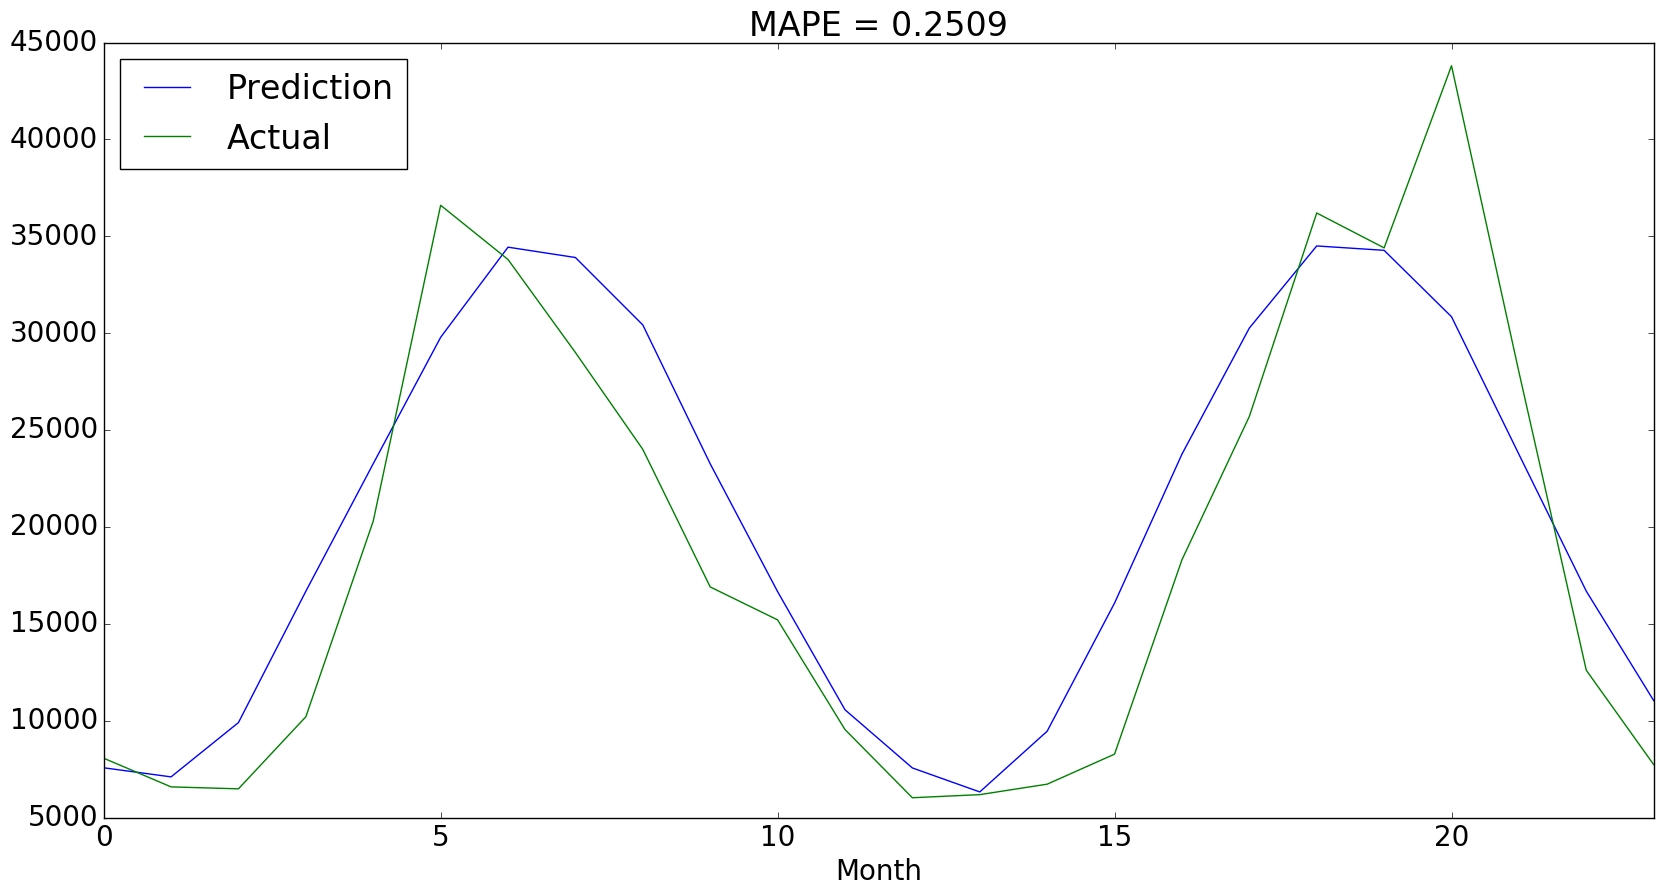

In [ ]:
# create and fit the Stacked LSTM network
batch_size=100
model2 = kModels.Sequential()
model2.add(kLayers.LSTM(96, batch_size=batch_size, input_shape=(1, lookback), return_sequences=True))
model2.add(kLayers.Dropout(0.1))
model2.add(kLayers.LSTM(48))
model2.add(kLayers.Dense(lookahead))
model2.compile(loss='mape', optimizer='adam')
model2.fit(trainX, trainY, epochs=15, batch_size=batch_size, verbose=1)

# visual
feedData = df1.WaterFlow['1972':'1976'].copy()
feedX = scaler.transform(feedData.values.reshape(-1, 1)).reshape(1, 1, lookback).astype('float32')
prediction2 = model2.predict(feedX)
predictionRaw = scaler.inverse_transform(prediction2.reshape(-1, 1))
actual1 = df1.WaterFlow['1977':'1978'].copy().values.reshape(-1, 1)
MAPE = (np.abs(predictionRaw-actual1)/actual1).mean()

plt.plot(predictionRaw, label='Prediction')
plt.plot(actual1, label='Actual')
plt.title("MAPE = %.4f" % MAPE)
plt.legend(loc='best')
plt.xlim((0, 23))
plt.xlabel("Month")
plt.show()

不同程度的疊加LSTM

In [ ]:
# stacked LSTM
def SLSTM(epoch=10, stacks=1, batchsize=5):
    batch_size=batchsize
    model2 = kModels.Sequential()
    model2.add(kLayers.LSTM(48, batch_size=batchsize, input_shape=(1, lookback), return_sequences=True))
    model2.add(kLayers.Dropout(0.1))
    for i in range(stacks-1):
        model2.add(kLayers.LSTM(32, return_sequences=True))
        model2.add(kLayers.Dropout(0.1))
        model2.add(kLayers.LSTM(32, return_sequences=False))
        model2.add(kLayers.Dense(lookahead))
        model2.compile(loss='mape', optimizer='adam')
        t0 = time()
        model2.fit(trainX, trainY, epochs=epoch, batch_size=batch_size, verbose=1)
        
        feedData = df1.WaterFlow['1972':'1976'].copy()
        feedX = scaler.transform(feedData.values.reshape(-1, 1)).reshape(1, 1, lookback).astype('float32')
        prediction2 = model2.predict(feedX)
        predictionRaw = scaler.inverse_transform(prediction2.reshape(-1, 1))
        actual1 = df1.WaterFlow['1977':'1978'].copy().values.reshape(-1, 1)
        deltatime = time()-t0
        MAPE = (np.abs(predictionRaw-actual1)/actual1).mean()
        print("Epoch= %.1f, MAPE=%.5f, 消耗時間=%.4f 秒" % (epoch, MAPE, deltatime))

In [ ]:
for epoch in [4,5,6,7,8,9,10]:
    SLSTM(epoch, stacks=2, batchsize=5)

Epoch 1/4
1261/1261 [==============================] - 4s 4ms/step - loss: 64.0358
Epoch 2/4
1261/1261 [==============================] - 4s 3ms/step - loss: 35.0963
Epoch 3/4
1261/1261 [==============================] - 4s 3ms/step - loss: 32.0482
Epoch 4/4
1261/1261 [==============================] - 4s 3ms/step - loss: 30.8959
Epoch= 4.0, MAPE=0.18467, 消耗時間=17.4101 秒
Epoch 1/5
1261/1261 [==============================] - 4s 3ms/step - loss: 65.9036
Epoch 2/5
1261/1261 [==============================] - 4s 3ms/step - loss: 36.1536
Epoch 3/5
1261/1261 [==============================] - 4s 3ms/step - loss: 31.9505
Epoch 4/5
1261/1261 [==============================] - 4s 3ms/step - loss: 30.5391
Epoch 5/5
1261/1261 [==============================] - 4s 3ms/step - loss: 29.9693
Epoch= 5.0, MAPE=0.25305, 消耗時間=21.7001 秒
Epoch 1/6
1261/1261 [==============================] - 4s 4ms/step - loss: 65.3542
Epoch 2/6
1261/1261 [==============================] - 4s 3ms/step - loss: 36.3797
Epoch

下面我們使用國際航空旅客數量作為例子來展示ARIMA模型的建模過程。使用這個資料是因為從圖像上看這個資料具有很強的趨勢和週期性，因此能夠充分展示建模的不同步驟。

原始資料平穩性檢驗
統計量           -0.773461
p-值            0.826794
滯後量           13.000000
觀測值數量        106.000000
臨界值 (5%)      -2.889217
臨界值 (10%)     -2.581533
臨界值 (1%)      -3.493602
dtype: float64
局部資料平穩性檢驗


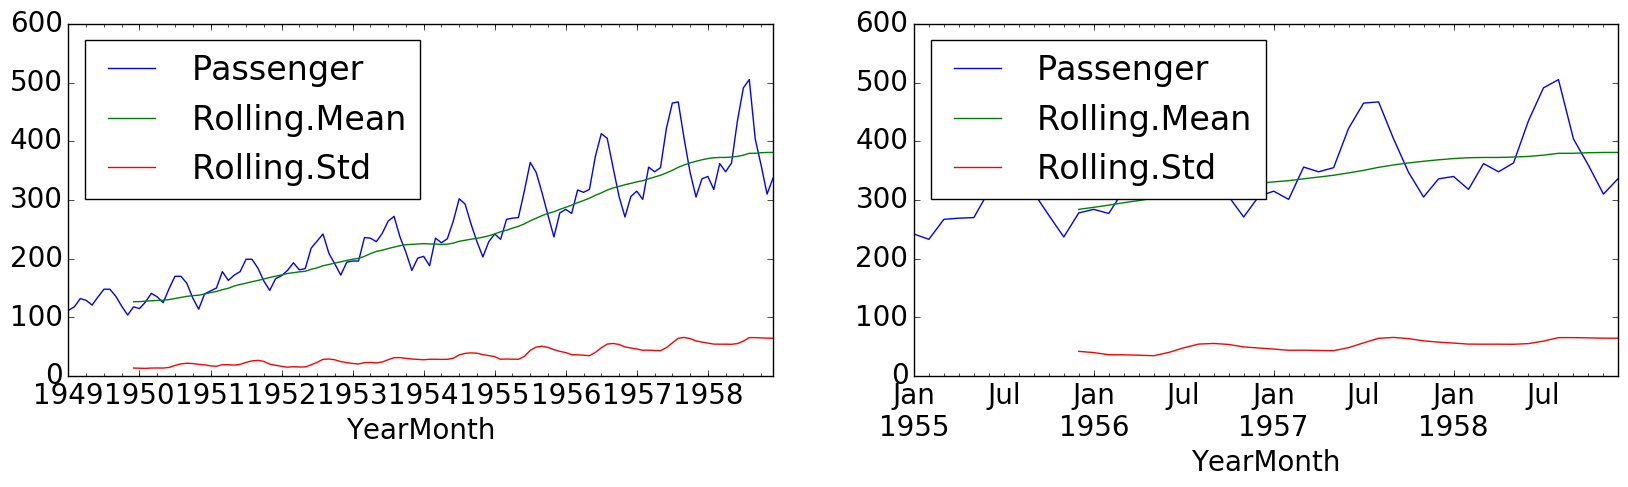

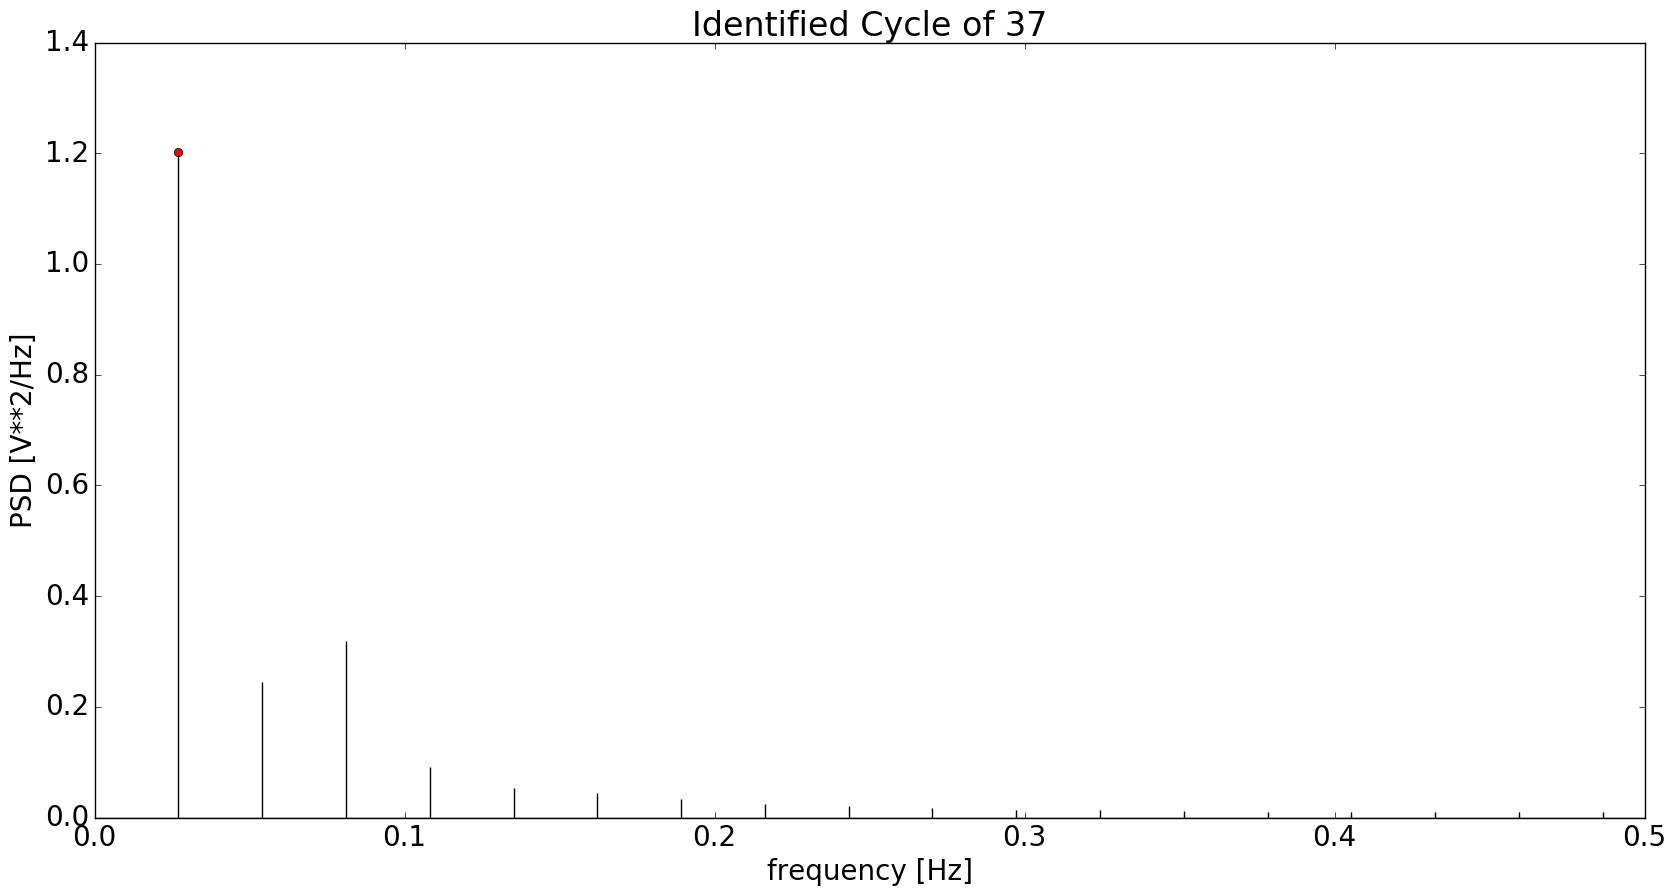

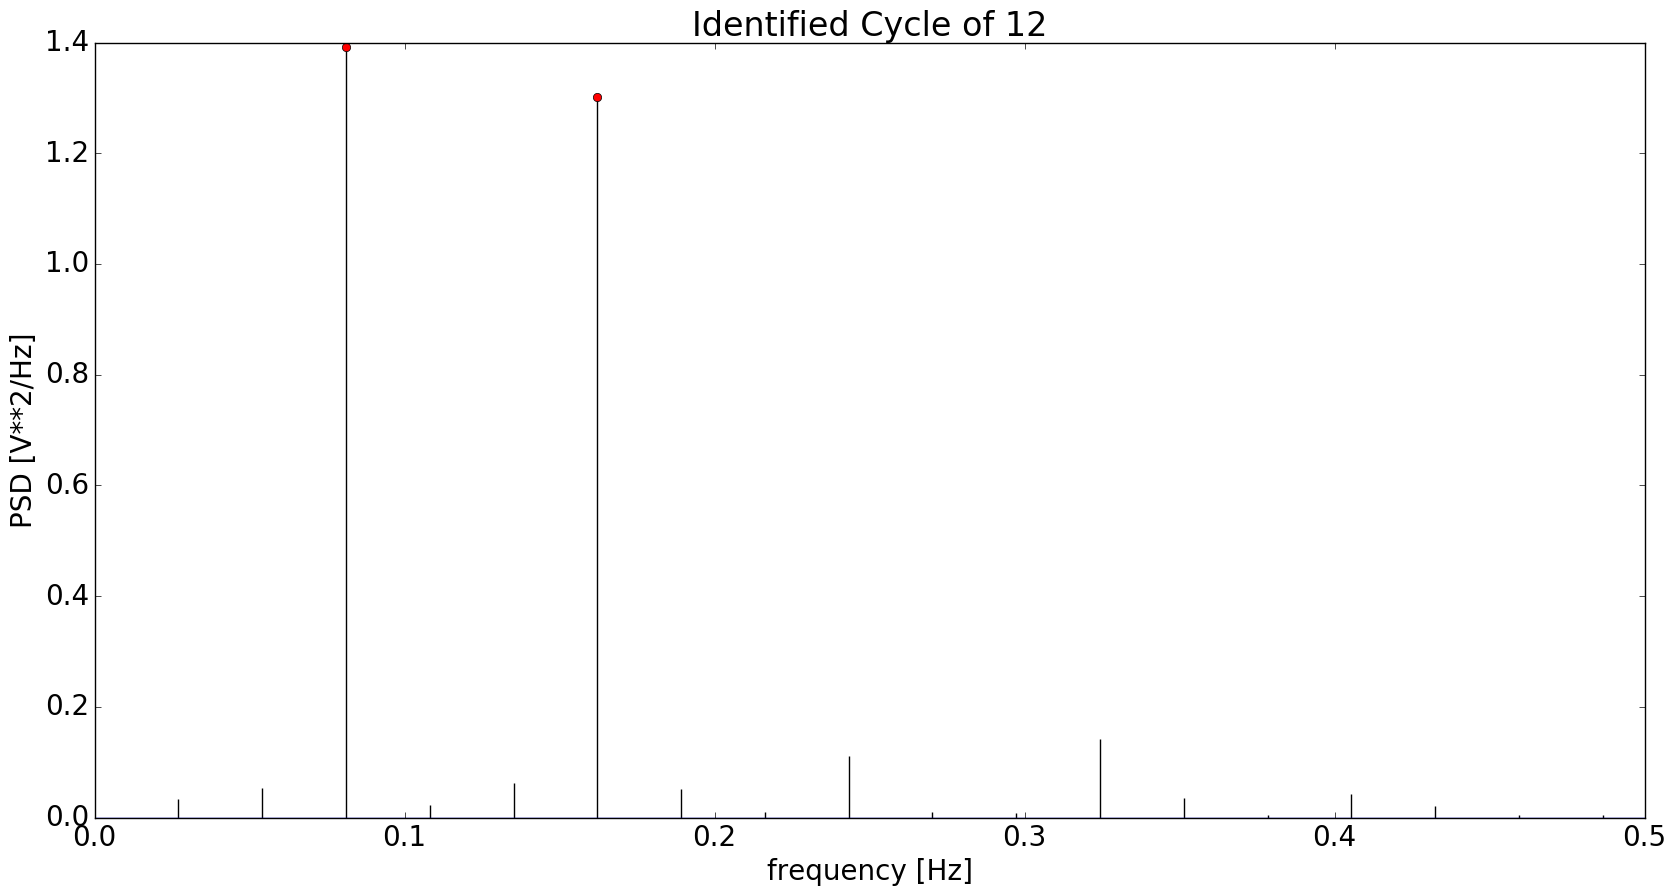

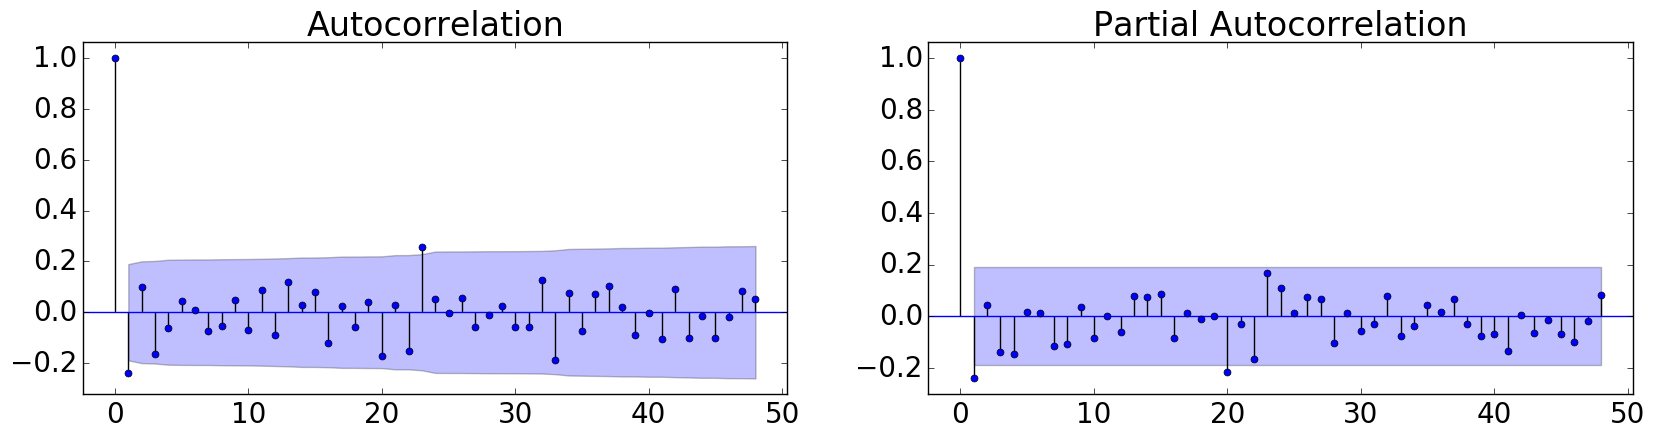

In [ ]:

# model international passensger data
cutoff=21
train2 = df2.Passenger[:-cutoff]
test2 = df2.Passenger[-cutoff:]

fig = plt.figure()
ax0 = fig.add_subplot(221)
adftest, dftest0=test_stationarity(train2)
dftest0.plot(ax=ax0)
print('原始資料平穩性檢驗')
print(adftest)

ax1 = fig.add_subplot(222)
adftest, dftest1=test_stationarity(train2['1955':'1960'])
dftest1.plot(ax=ax1)
print('局部資料平穩性檢驗')

# identify cycle
index, f, Power = CalculateCycle(train2)

train2d1 = train2.diff(1)[1:]
index, f, Power = CalculateCycle(train2d1)

season=12
train2d1s12 = train2d1.diff(season)[season:]

nlags=48
fig = plt.figure()
ax0 = fig.add_subplot(221)
sm.graphics.tsa.plot_acf(train2d1s12, ax=ax0, lags=48)
ax1 = fig.add_subplot(222)
sm.graphics.tsa.plot_pacf(train2d1s12, ax=ax1, lags=48)
plt.show()

下面來擬合SARIMA模型

In [ ]:
# fit a seasonal ARIMA model 
arima_order3 = (0,1,0)
season_order3 = (1,1,0,12)
mod1 = sm.tsa.statespace.SARIMAX(train2, trend='c', order=arima_order3, seasonal_order=season_order3).fit()
pred=mod1.predict()
print(mod1.summary())

                                 Statespace Model Results                                 
Dep. Variable:                          Passenger   No. Observations:                  120
Model:             SARIMAX(0, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -402.338
Date:                            Thu, 26 Apr 2018   AIC                            810.677
Time:                                    18:05:07   BIC                            819.039
Sample:                                01-01-1949   HQIC                           814.073
                                     - 12-01-1958                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0204      1.026     -0.020      0.984      -2.031       1.990
ar.S.L12      -0.1020      0.085   

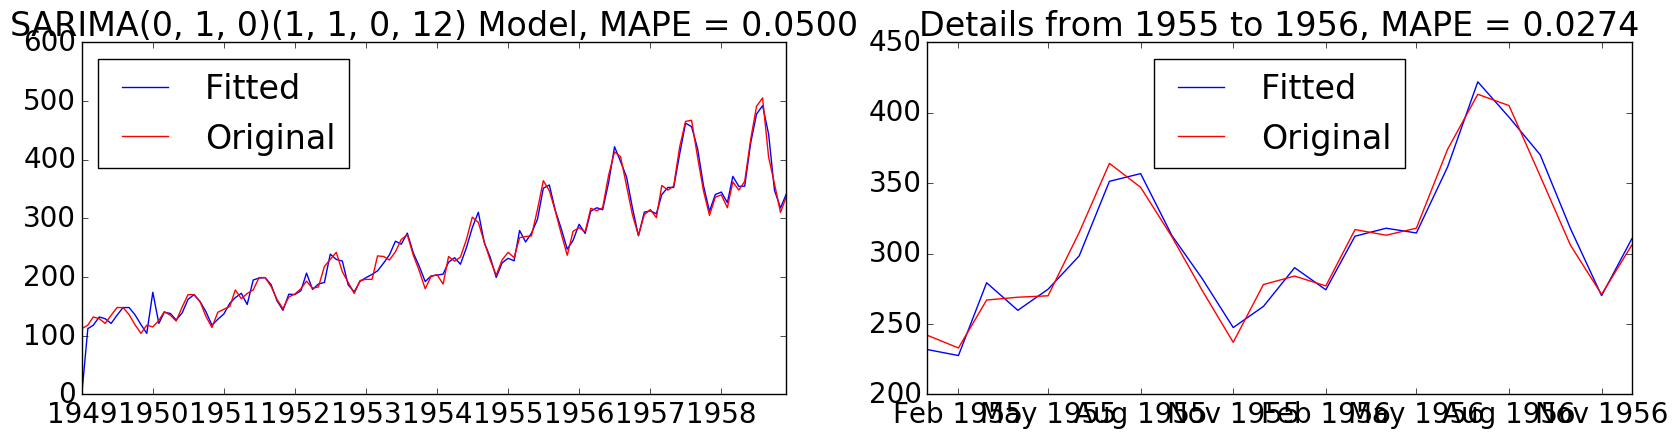

In [ ]:
subtrain = train2['1955':'1956']
MAPE = (np.abs(train2-pred)/train2).mean()
subMAPE = (np.abs(subtrain-pred['1955':'1956'])/train2).mean()

fig = plt.figure()
ax0 = fig.add_subplot(221)
plt.plot(pred, label='Fitted'); 
plt.plot(train2, color='red', label='Original')
plt.legend(loc='best')
plt.title("SARIMA%s%s Model, MAPE = %.4f" % (arima_order3, season_order3, MAPE))

ax1 = fig.add_subplot(222)
plt.plot(pred['1955':'1956'], label='Fitted'); 
plt.plot(subtrain, color='red', label='Original')
plt.legend(loc='best')
plt.title("Details from 1955 to 1956, MAPE = %.4f" % subMAPE)

plt.savefig("./data/timeseries/Flight_SARIMA_plot.png")
plt.show()

12.371132954124569


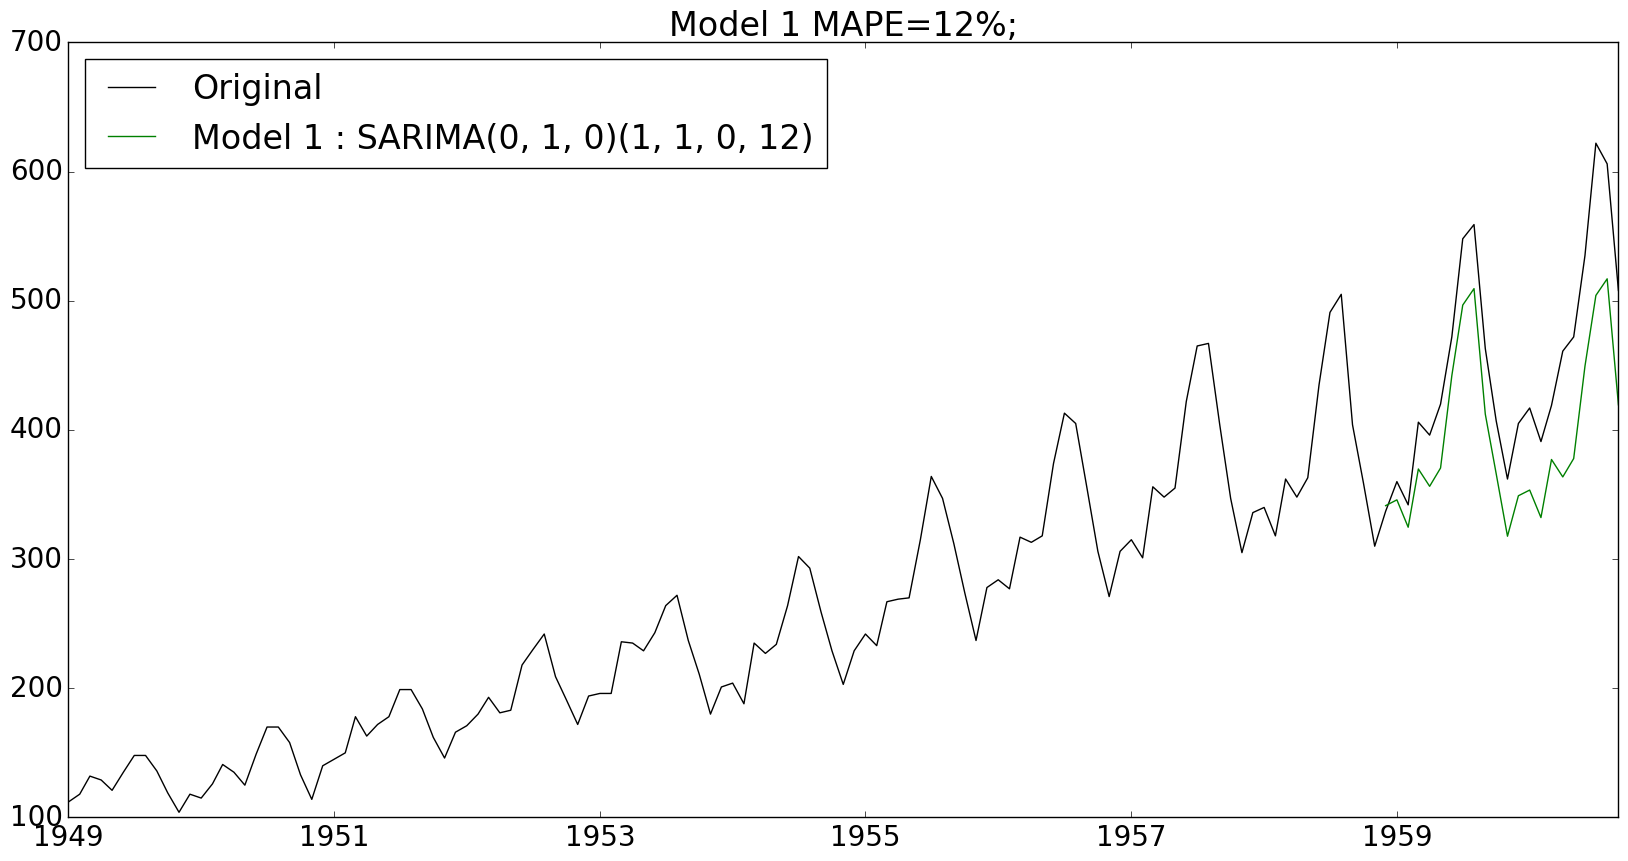

In [ ]:
forecast1 = mod1.predict(start = '1958-12-01', end='1960-09-01' , dynamic= True) 
MAPE1 = ((test2-forecast1[1:]).abs() / test2).mean()*100
print(MAPE1)

plt.plot(df2, color='black', label='Original')
plt.plot(forecast1, color='green', label='Model 1 : SARIMA' + str(arima_order3) + str(season_order3))
plt.legend(loc='best')
plt.title('Model 1 MAPE=%.f%%;' %(MAPE1))

plt.savefig("./data/timeseries/Flight_SARIMA_pred.png")

下面為LSTM模型準備資料

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
trainstd2 = scaler.fit_transform(train2.values.astype(float).reshape(-1, 1))
teststd2 = scaler.transform(test2.values.astype(float).reshape(-1, 1))

In [ ]:
lookback=60
lookahead=24
timestep=1
trainX2, trainY2 = create_dataset(trainstd2, timestep=1, look_back=lookback, look_ahead=lookahead)
trainX2 = trainX2.astype('float32')
trainY2 = trainY2.astype('float32')

In [ ]:
%%time
# build LSTM 
batch_size=1
model = kModels.Sequential()
model.add(kLayers.LSTM(96, batch_size=batch_size, input_shape=(1, lookback), kernel_initializer='he_uniform'))
#model.add(kLayers.Dense(32))
model.add(kLayers.Dense(lookahead))
#model.compile(loss='mean_squared_error', optimizer='adam')
model.compile(loss='mape', optimizer='adam')
model.fit(trainX2, trainY2, epochs=30, batch_size=batch_size, verbose=0)

Wall time: 13 s


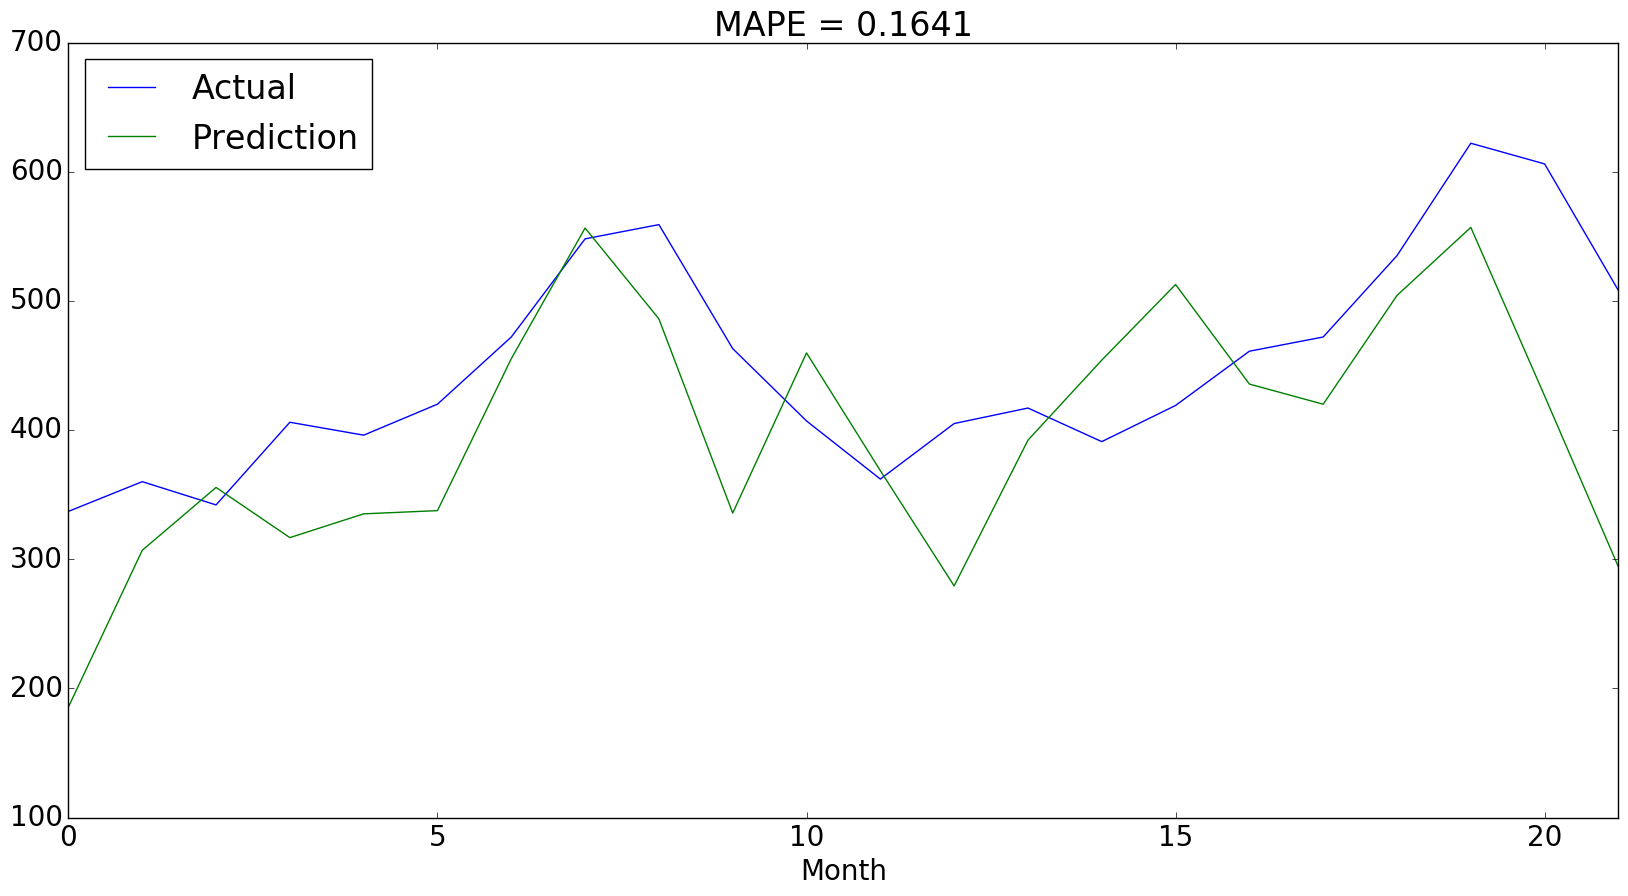

In [ ]:
feedData = scaler.transform(df2.Passenger['1954-01-01':'1958-12-01'].values.reshape(-1, 1)).copy()
feedX = (feedData).reshape(1, 1, lookback)
feedX = (feedX).astype('float32')
prediction1 = model.predict(feedX)
#prediction1.shape

predictionRaw = scaler.inverse_transform(prediction1.reshape(-1, 1))[:-2]
#predictionRaw = (prediction1.reshape(-1, 1))
actual1 = df2.Passenger['1958-12-01':'1960-09-01'].copy().values.reshape(-1, 1)
MAPE = (np.abs(predictionRaw-actual1)/actual1).mean()
plt.plot(actual1, label='Actual')
plt.plot(predictionRaw, label='Prediction')
plt.title("MAPE = %.4f" % MAPE)
plt.legend(loc='best')
plt.xlim((0, 21))
plt.xlabel("Month")

plt.savefig("./data/timeseries/Flight_LSTM_pred.png")
plt.show()

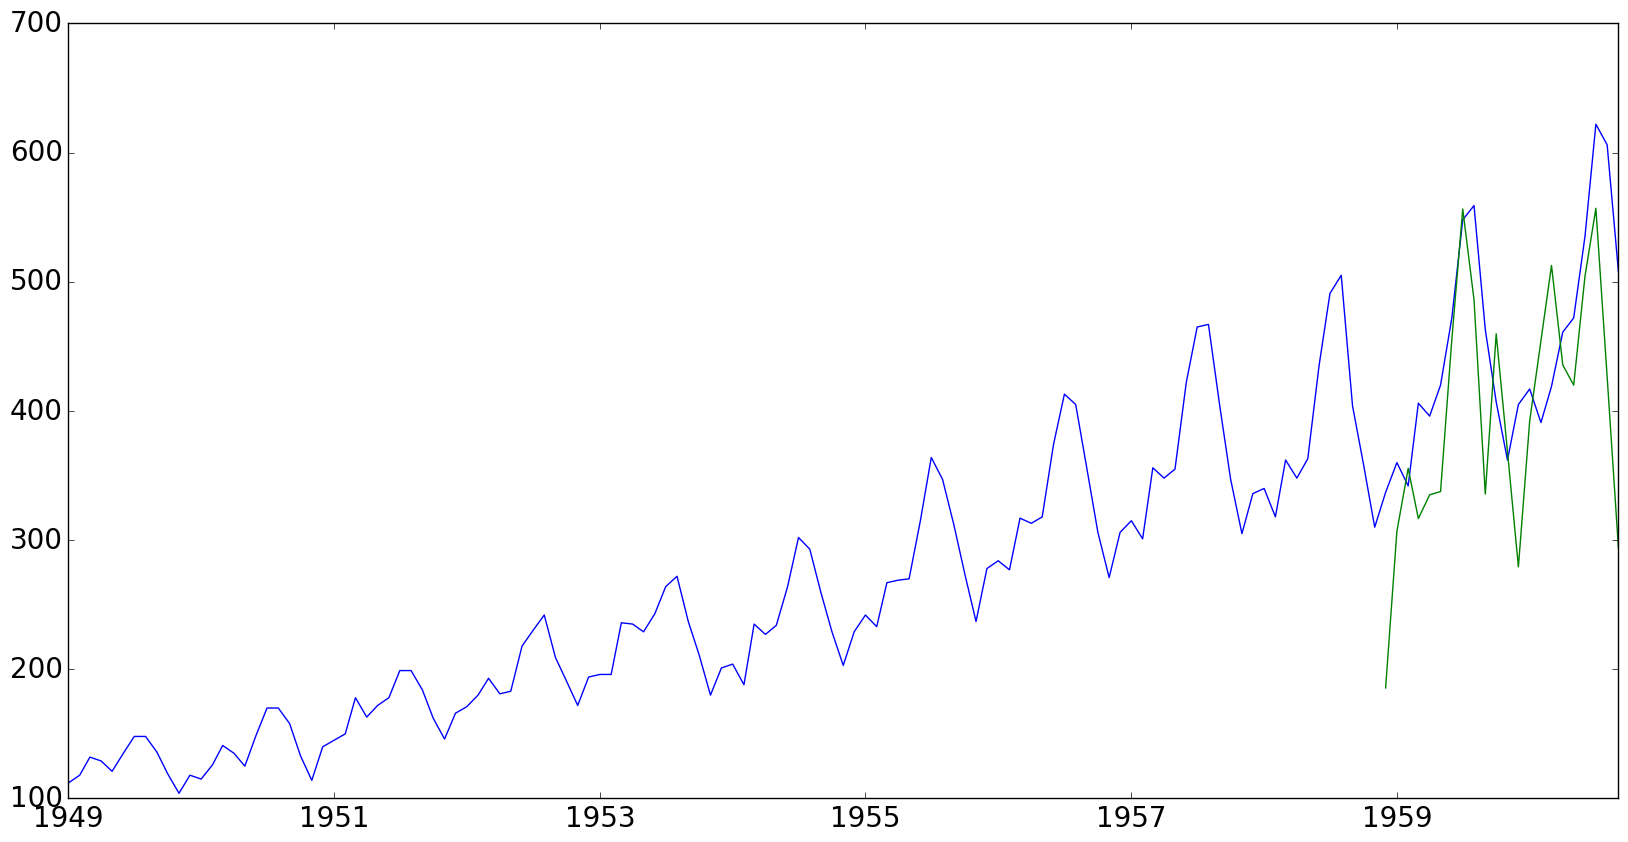

In [ ]:
predAll=df2.Passenger*np.nan
predAll[-22:] = predictionRaw.reshape(-1)
plt.plot(df2.Passenger)
plt.plot(predAll)
plt.show()

使用消除異方差的資料建模

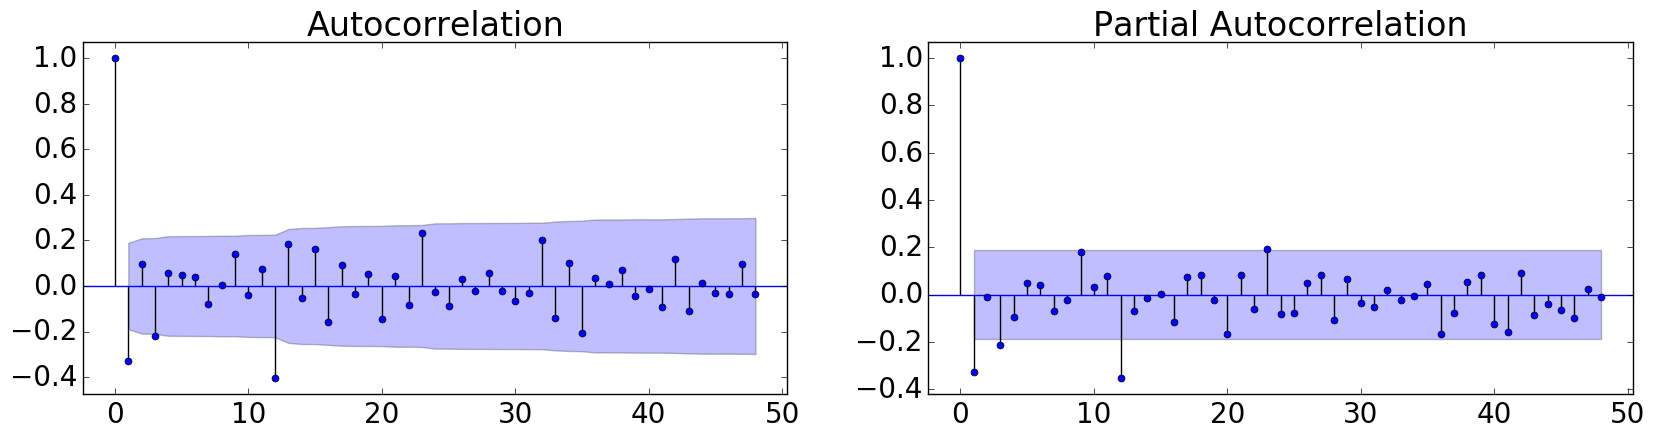

                                 Statespace Model Results                                 
Dep. Variable:                          Passenger   No. Observations:                  120
Model:             SARIMAX(0, 1, 0)x(2, 1, 1, 12)   Log Likelihood                 192.159
Date:                            Thu, 26 Apr 2018   AIC                           -376.318
Time:                                    18:06:49   BIC                           -365.168
Sample:                                01-01-1949   HQIC                          -371.790
                                     - 12-01-1958                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.0862      0.421     -0.205      0.838      -0.911       0.739
ar.S.L24      -0.0920      0.212   

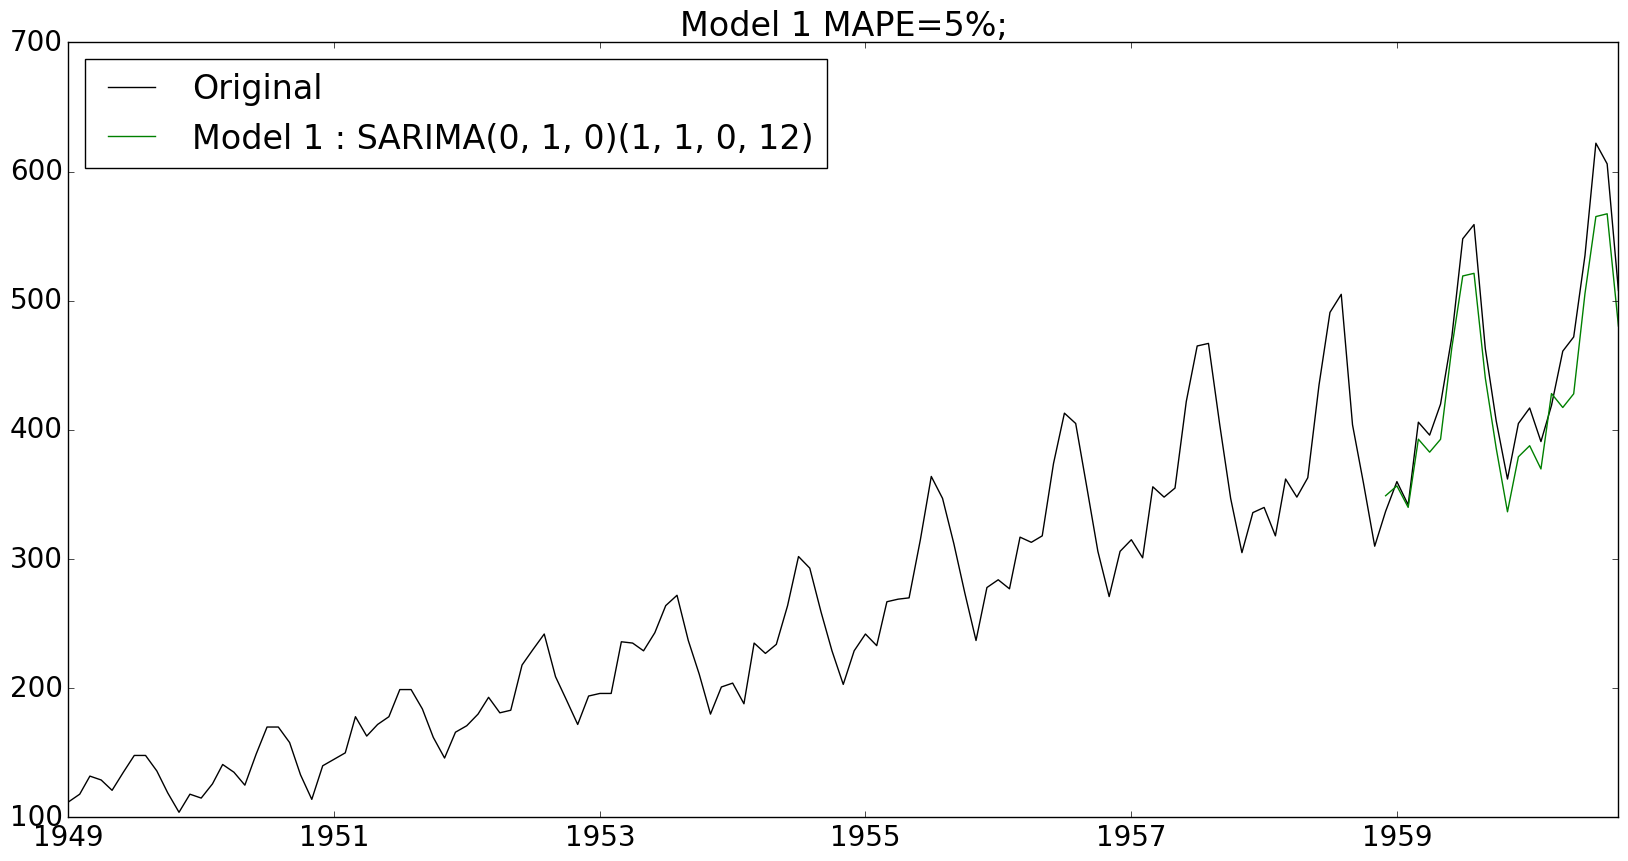

In [ ]:
train2log = np.log(train2)
test2log = np.log(test2)

train2logd1s12 = (train2log.diff(1)[1:]).diff(12)[12:]
fig = plt.figure()
ax0 = fig.add_subplot(221)
sm.graphics.tsa.plot_acf(train2logd1s12, ax=ax0, lags=48)

ax1 = fig.add_subplot(222)
sm.graphics.tsa.plot_pacf(train2logd1s12, ax=ax1, lags=48)
plt.savefig("./data/timeseries/Flight_log_ACF_PACF.png")
plt.show()
plt.close()


mod1 = sm.tsa.statespace.SARIMAX(train2log, trend='n', order=(0,1,0), seasonal_order=(2,1,1,12)).fit()
pred=mod1.predict()
print(mod1.summary())

forecast1 = mod1.predict(start = '1958-12-01', end='1960-09-01' , dynamic= True) 
forecast1 = np.exp(forecast1)
MAPE1 = ((test2-forecast1[1:]).abs() / test2).mean()*100
print(MAPE1)

plt.plot(df2, color='black', label='Original')
plt.plot(forecast1, color='green', label='Model 1 : SARIMA' + str(arima_order3) + str(season_order3))
plt.legend(loc='best')
plt.title('Model 1 MAPE=%.f%%;' %(MAPE1))

plt.savefig("./data/timeseries/Flight_log_SARIMA_pred.png")
plt.show()
plt.close()

In [ ]:
%%time
scaler2 = MinMaxScaler(feature_range=(0, 1))
trainlogstd2 = scaler2.fit_transform(train2log.values.astype(float).reshape(-1, 1))
testlogstd2 = scaler2.transform(test2log.values.astype(float).reshape(-1, 1))  

lookback=60
lookahead=24
timestep=1, 
trainlogX2, trainlogY2 = create_dataset(trainlogstd2, timestep=1, look_back=lookback, look_ahead=lookahead)
trainlogX2 = trainlogX2.astype('float32')
trainlogY2 = trainlogY2.astype('float32')

batch_size=10
model = kModels.Sequential()
model.add(kLayers.LSTM(96, input_shape=(1, lookback), kernel_initializer='he_uniform'))
model.add(kLayers.Dense(lookahead))
model.compile(loss='mape', optimizer='adam')
model.fit(trainlogX2, trainlogY2,  epochs=60, batch_size=batch_size, verbose=1)

Epoch 1/60
37/37 [==============================] - 0s 7ms/step - loss: 98.2004
Epoch 2/60
37/37 [==============================] - 0s 4ms/step - loss: 84.0435
Epoch 3/60
37/37 [==============================] - 0s 3ms/step - loss: 69.0847
Epoch 4/60
37/37 [==============================] - 0s 2ms/step - loss: 52.9434
Epoch 5/60
37/37 [==============================] - 0s 4ms/step - loss: 37.8778
Epoch 6/60
37/37 [==============================] - 1s 15ms/step - loss: 26.9157
Epoch 7/60
37/37 [==============================] - 0s 4ms/step - loss: 18.9680
Epoch 8/60
37/37 [==============================] - 0s 10ms/step - loss: 14.8111
Epoch 9/60
37/37 [==============================] - 0s 3ms/step - loss: 12.9949
Epoch 10/60
37/37 [==============================] - 0s 4ms/step - loss: 12.6590
Epoch 11/60
37/37 [==============================] - 0s 3ms/step - loss: 12.3551
Epoch 12/60
37/37 [==============================] - 0s 3ms/step - loss: 10.7821
Epoch 13/60
37/37 [================

對數變換以後深度學習模型的預測效果較差。

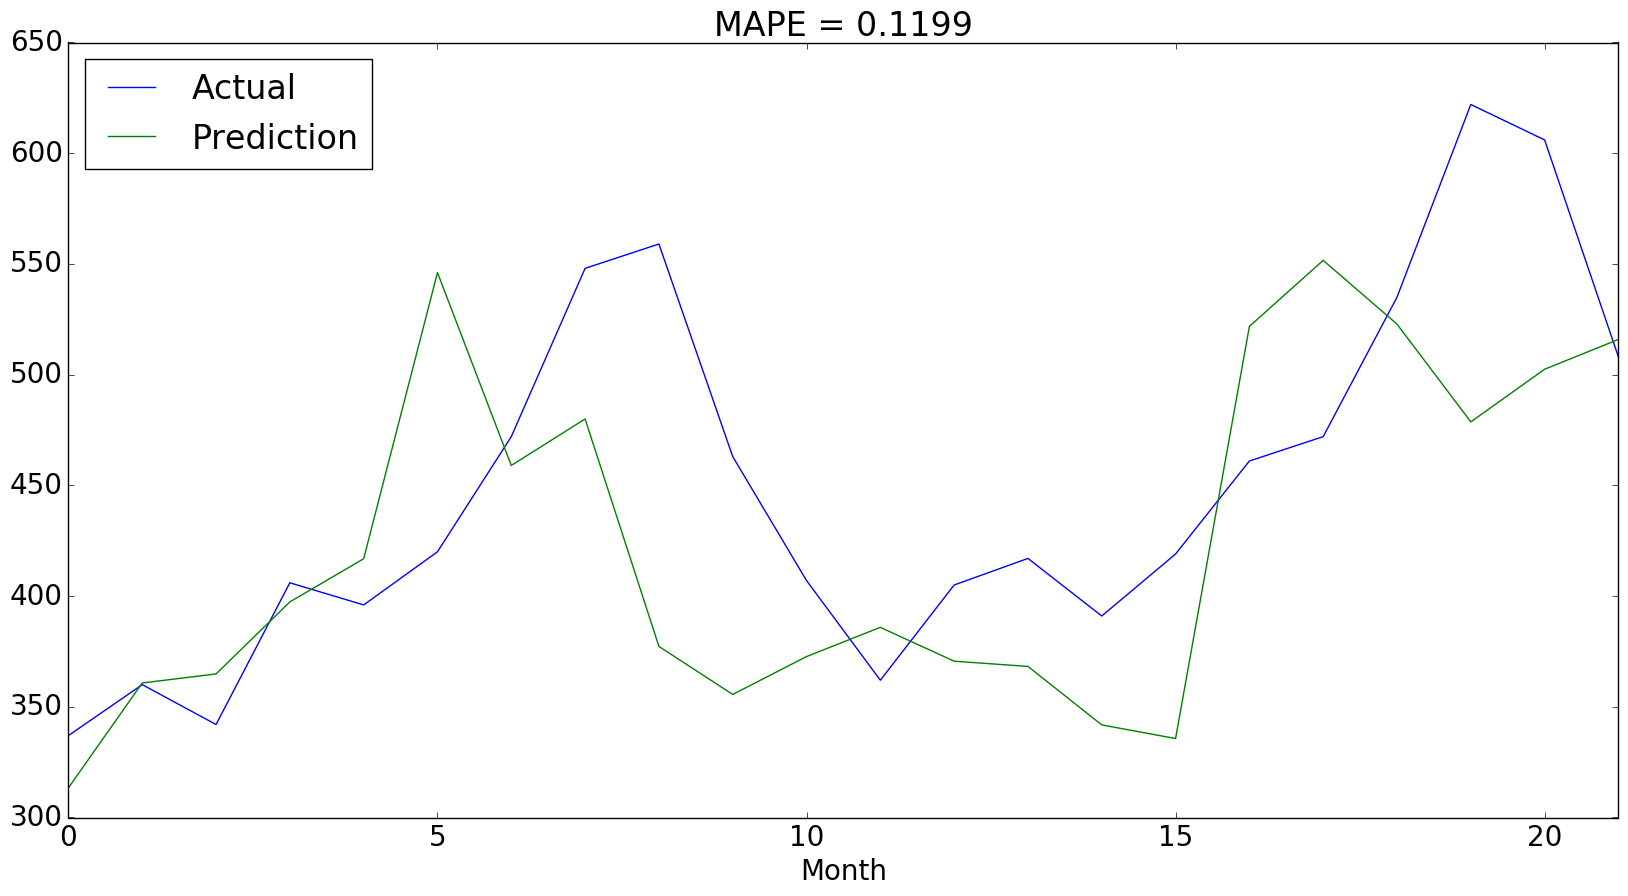

In [ ]:
feedData = df2.Passenger['1954-01-01':'1958-12-01'].values.reshape(-1, 1).copy()
feedData = np.log(feedData)
feedData = scaler2.transform(feedData)
feedX = (feedData).reshape(1, 1, lookback).astype('float32')
prediction1 = model.predict(feedX)
#prediction1.shape

prediction1 = scaler2.inverse_transform(prediction1.reshape(-1, 1))[:-2]
#predictionRaw = (prediction1).reshape(-1, 1)
predictionRaw = np.exp(prediction1.reshape(-1, 1))
actual1 = df2.Passenger['1958-12-01':'1960-09-01'].copy().values.reshape(-1, 1)
MAPE = (np.abs(predictionRaw[:]-actual1)/actual1).mean()
plt.plot(actual1, label='Actual')
plt.plot(predictionRaw, label='Prediction')
plt.title("MAPE = %.4f" % MAPE)
plt.legend(loc='best')
plt.xlim((0, 21))
plt.xlabel("Month")
plt.show()

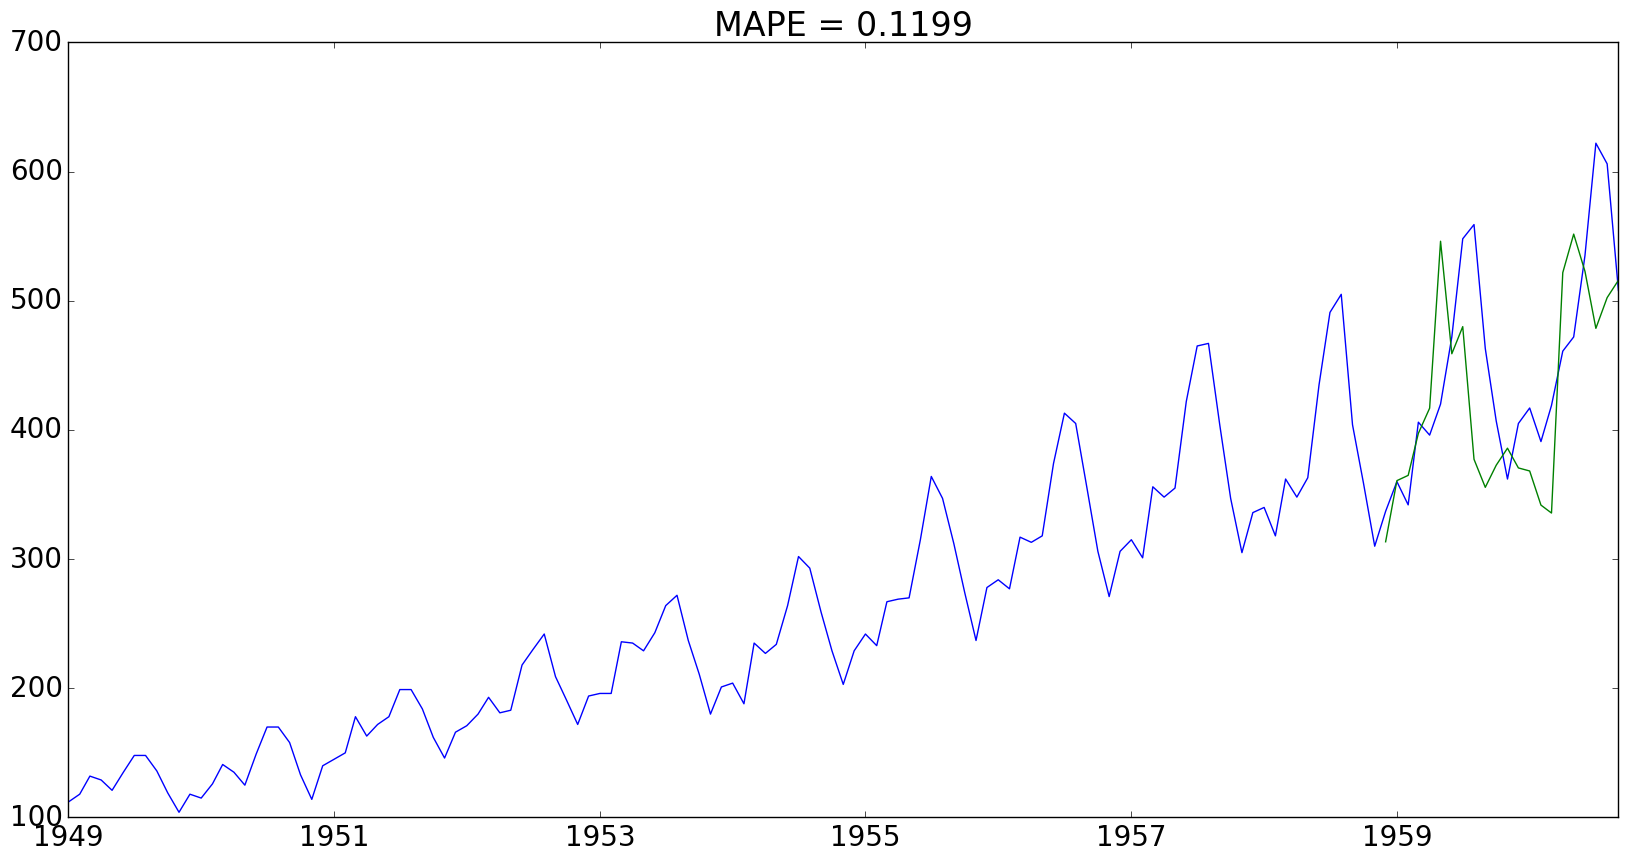

In [ ]:
predAll=df2.Passenger*np.nan
predAll[-22:] = predictionRaw.reshape(-1)
plt.plot(df2.Passenger)
plt.plot(predAll)
plt.title("MAPE = %.4f" % MAPE)
plt.show()

# 帶引數的LSTM模型

如果帶有引數，該如何用LSTM來建模呢？該如何組織資料呢？我們下面舉一個簡單的股價預測模型。

In [ ]:
import time
try:
    from  pandas_datareader import data
except ImportError:
    !pip install pandas_datareader
    from  pandas_datareader import data 
    
try:
    import datetime
except ImportError:
    !pip install datetime
    import datetime
    
def get_stock_data(contract, s_year, s_month, s_day, e_year, e_month, e_day):
    """
    code borrowed from CNTK example, default to YAHOO backend
    Args:
        contract (str): the name of the stock/etf
        s_year (int): start year for data
        s_month (int): start month
        s_day (int): start day
        e_year (int): end year
        e_month (int): end month
        e_day (int): end day
    Returns:
        Pandas Dataframe: Daily OHLCV bars
    """
    start = datetime.datetime(s_year, s_month, s_day)
    end = datetime.datetime(e_year, e_month, e_day)
    
    retry_cnt, max_num_retry = 0, 10
    
    while(retry_cnt < max_num_retry):
        try:
            bars = data.DataReader(contract,"yahoo", start, end)
            return bars
        except:
            retry_cnt += 1
            time.sleep(np.random.randint(1,10)) 
            
    print("Yahoo Finance is not reachable")
    raise Exception('Yahoo Finance is not reachable')

In [ ]:
import pandas_datareader as pdr
msft=get_stock_data('MSFT', 2006, 1, 1, 2017, 11, 1)

Yahoo Finance is not reachable


Exception: Yahoo Finance is not reachable

下面看看過去一年微軟股票的走勢。

In [ ]:
msft.Close[-365:].plot()
plt.show()

NameError: name 'msft' is not defined

In [ ]:
index, f, power = CalculateCycle(msft.Close.diff(1)[1:], lags=90)

NameError: name 'msft' is not defined

In [ ]:
1/f[index]

array([ 12.33333333,   6.16666667])

In [ ]:
b=(msft.Close.diff(1)[-365:]>0)*2-1
b.plot()
index, f, power = CalculateCycle(b)

NameError: name 'msft' is not defined

In [ ]:
1/f[index]

array([ 12.33333333,   6.16666667])

我們準備用過去7天的股價和其他量價資料來預測明天的收盤價。這個模型並不具有真實的經濟含義和預測能力，主要是用來展示如何在LSTM裡面引入隨時間變化的外生變數。

一般來講，股價的預測是通過對於股票的日均回報率時間序列進行建模來實現的。

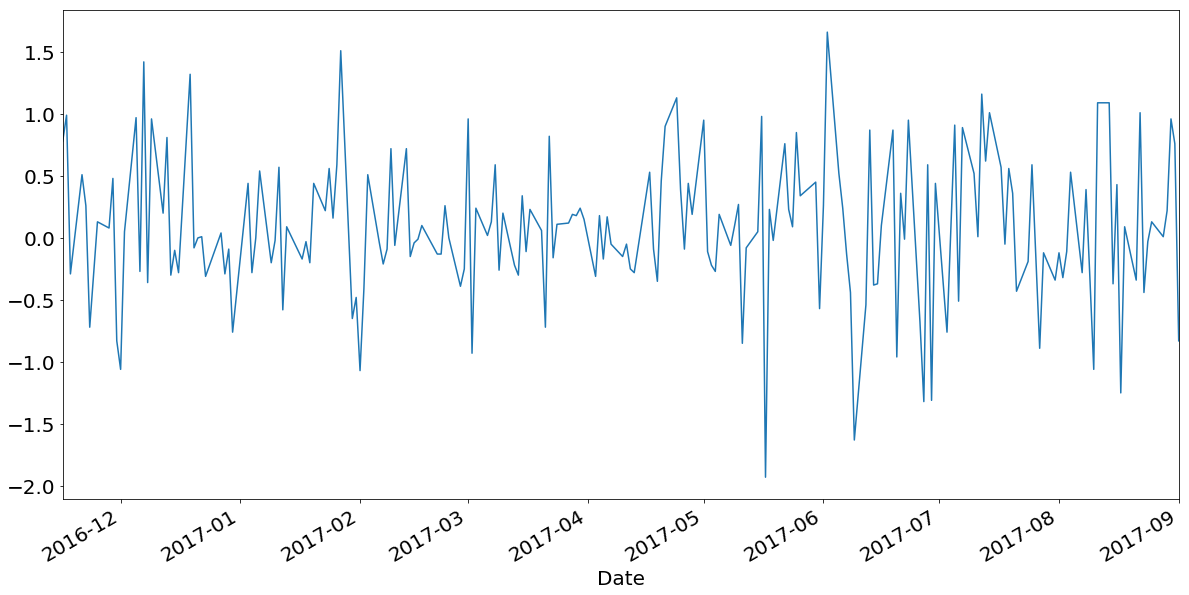

In [ ]:
msft.Close.diff(1)[-200:].plot()

In [ ]:
Y = msft.Close.shift(1)

我們現在來構造特徵向量。處於展示的目的，我們假設特徵值是過去7天的交易量和收盤價，待預測的是未來2天的漲跌情況。這裡7和2只是隨意設定的值，讀者可以試試別的參數值。

為了有效構造多輸入變數的張量供LSTM模型使用，原來的create_dataset函數需要進行修改。在原來的函數裡，我們使用了statsmodel庫裡的lagmat函數，這裡我們需要自己直接在原有的矩陣上進行對下標進行操作。

目標資料集的格式為一個三維的張量，其中第一維是代表樣本，第二維代表時間步（或者說是往回看的時間），第三維則是每個時間步對應的當期特徵向量值，比如在這個股票資料裡就為對應時間t的交易量，時間t的收盤價，時間t-1的收盤價等。

In [ ]:
def create_dataset3(Xdf, Ydf, timesteps=1, look_ahead=1):
    X =  np.zeros((Xdf.shape[0], timesteps, Xdf.shape[1]), dtype=np.float)
    y = np.zeros((Ydf.shape[0], look_ahead), dtype=np.float)
    for i in range(Xdf.shape[0]):
        for t in range(timesteps):
            char=sentence[t]
            X[i, t, char_indices[char]] = 1
        y[i, char_indices[next_chars[i]]] = 1

In [ ]:
def create_dataset2(Xdf, Ydf, look_back=1):
    dataX, dataY = [], []
    for i in range(len(Xdf) - look_back - 1):
        a = Xdf.iloc[i:(i + look_back), :]
        dataX.append(a)
        dataY.append(Ydf.iloc[i + look_back, :])
    return dataX, dataY

In [ ]:
dato = pd.read_csv("d:\\Temp\\dato.txt", header=0)
dato.head()

FileNotFoundError: File b'd:\\Temp\\dato.txt' does not exist

In [ ]:
dfX = dato.iloc[:, :2]
dfY = dato.iloc[:, [2]]

In [ ]:
dfX2, dfY2 = create_dataset2(dfX, dfY, look_back=3)

In [ ]:
dfY2[0]

 Y    287
Name: 3, dtype: int64